# P3 Concevez une application au service de la santé publique 

L'agence <span style='color:blue'> <a href = "http://www.santepubliquefrance.fr/">"*Santé publique France*" </a></span> a lancé un appel à projets pour trouver des idées innovantes d’applications en lien avec l'alimentation. <br>
Vous souhaitez y participer et proposer une idée d’application.

Le jeu de données <font color='orange'>Open Food Facts</font> est disponible sur le <a href = "https://world.openfoodfacts.org/">site officiel</a> (ou disponible à <a href ="https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/parcours-data-scientist/P2/fr.openfoodfacts.org.products.csv.zip">ce lien</a> en téléchargement).
<br>
Les variables sont définies à <a href = "https://world.openfoodfacts.org/data/data-fields.txt">cette adresse</a>

Les champs sont séparés en quatre sections :

- Les informations générales sur la fiche du produit : nom, date de modification, etc.
- Un ensemble de tags : catégorie du produit, localisation, origine, etc.
- Les ingrédients composant les produits et leurs additifs éventuels.
- Des informations nutritionnelles : quantité en grammes d’un nutriment pour 100 grammes du produit.

Notre idée est de créer une application mobile nommé livebetterandlonger

Cette application permettra au utilisateur d'ameliorer leur alimentaion, en leur proposant lors de l'achat des course d'obtenir une liste de produit similaire plus sain, c'est à dire en terme possedant un meilleur nutriscore. 


Comment:
lors de la selection d'un aliment, grace à son smartphone le client scannera le code barre de l'aliment, et obtiendra une liste de produit ordonnée par qualité nutritive au moins aussi interressant que le produit scanné.

Ce notebook a pour vocation à détailler le processus de nettoyage et de traitement necessaire pour la mise en place de notre application lookalike.

Les données sont toutes issues de l'initiative Open Food Facts dans le cadre de l'appel à projets de l'Agence Santé Publique France.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
import os

import missingno as msno

In [2]:
%%time
if os.path.exists("fr.openfoodfacts.org.products.csv"):
    openfoodfacts = pd.read_csv("fr.openfoodfacts.org.products.csv",sep='\t',low_memory=False)

Wall time: 11.9 s


prendre 1 echant en parametre / 
figer typ de chaq col

In [3]:
openfoodfacts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320772 entries, 0 to 320771
Columns: 162 entries, code to water-hardness_100g
dtypes: float64(106), object(56)
memory usage: 396.5+ MB


Le fichier comtient 106 variables numeriques et 56 varriables catégoriques.
Il y a trop de données pour tout afficher dans une cellule resultant de la methode info().
Nous etudirons les colonnes de type 'object' dans un premier temps.

In [4]:
pd.options.display.max_columns=60
openfoodfacts[openfoodfacts.columns[(openfoodfacts.dtypes==object) ].to_list()].describe().T

,count,unique,top,freq
code,320749,320749,0000000003087,1
url,320749,320749,http://world-fr.openfoodfacts.org/produit/0000...,1
creator,320770,3535,usda-ndb-import,169868
created_t,320769,189567,1489077120,20
created_datetime,320763,189568,2017-03-09T10:37:09Z,20
last_modified_t,320772,180495,1439141742,33
last_modified_datetime,320772,180495,2015-08-09T17:35:42Z,33
product_name,303010,221347,Ice Cream,410
generic_name,52795,38584,Pâtes alimentaires au blé dur de qualité supér...,201
quantity,104819,13826,500 g,4669


In [5]:
def test_na_nunique(col1,col2):
    '''
    Test number of Missing Value et number unique value
    '''
    return(col1.nunique() < col2.nunique() and abs(col1.notna().sum() - col2.notna().sum() ) <100)

def drop_duplicated_col(df):
    '''
    return list columns redundant to drop
    '''
    col_to_drop = []
    
    for col in df.columns :

        # les dates
        if len(col.split('_'))>=2 and col.split('_')[-1] == 't':  
            col_to_drop.append(col.replace('_t','_datetime'))


        if len(col.split('_'))==1 and col+'_fr' in openfoodfacts and col+'_tags' in openfoodfacts:
            # si 'fr' better than ''
            col_to_drop.extend(np.where(test_na_nunique(df[col+'_fr'] , df[col]), 
                                        np.where(test_na_nunique( df[col+'_fr'] , df[col+'_tags'] ),
                                                 [col,col+'_tags'],   # si 'fr'> '_tags' 
                                                 [col,col+'_fr']      # si 'fr'< '_tags' 
                                                ),
                                        # si 'fr' not better than ''
                                        np.where(test_na_nunique(df[col] , df[col+'_tags'] ),
                                                 [col+'_tags',col+'_fr'],
                                                 [col ,col+'_fr']
                                                )
                                       )
                              )
        elif len(col.split('_'))==1 and (col+'_fr' in openfoodfacts or col+'_tags' in openfoodfacts):

            if col+'_fr' in openfoodfacts:  
                col_to_drop.extend(np.where(test_na_nunique(df[col+'_fr'] , df[col]),
                                            [col],   # si 'fr'> ''
                                            [col+'_fr']      # si 'fr'< '' 
                                           )
                                  )

            elif col+'_tags' in openfoodfacts:
                # si 'fr' better than ''
                col_to_drop.extend(np.where(test_na_nunique(df[col+'_tags'] , df[col]),
                                            [col],   # si 'fr'> ''
                                            [col+'_tags']      # si 'fr'< '' 
                                           )
                                  )
        elif len(col.split('_'))>=2 and col +'_fr' in openfoodfacts or col+'_tags' in openfoodfacts:
            
            if (col+'_fr' in openfoodfacts) :
                col_to_drop.extend(np.where(test_na_nunique(df[col ] , df[col+'_fr']),
                                            [col+ '_fr'],   # si 'fr'> ''
                                            [col ]      # si 'fr'< '' 
                                           )
                                  )

            elif (col +'_tags' in openfoodfacts) :
                # si 'fr' better than ''
                col_to_drop.extend(np.where(test_na_nunique(df[col + '_tags'] , df[col]),
                                            [col],   # si 'fr'> ''
                                            [col +'_tags']      # si 'fr'< '' 
                                           )
                                  )
 
            
    return col_to_drop

In [6]:
list_col_to_drop = drop_duplicated_col(df = openfoodfacts)
list_col_to_drop

['created_datetime',
 'last_modified_datetime',
 'packaging',
 'brands',
 'categories',
 'categories_fr',
 'origins',
 'manufacturing_places',
 'labels',
 'labels_fr',
 'emb_codes',
 'cities_tags',
 'countries',
 'countries_tags',
 'allergens_fr',
 'traces',
 'traces_fr',
 'additives',
 'additives_fr',
 'ingredients_from_palm_oil_tags',
 'ingredients_that_may_be_from_palm_oil_tags',
 'states',
 'states_fr',
 'main_category']

In [7]:
data_cleaned = openfoodfacts.drop(columns=list_col_to_drop).copy()
del list_col_to_drop   

In [8]:
data_cleaned.head()

,code,url,creator,created_t,last_modified_t,product_name,generic_name,quantity,packaging_tags,brands_tags,categories_tags,origins_tags,manufacturing_places_tags,labels_tags,emb_codes_tags,first_packaging_code_geo,cities,purchase_places,stores,countries_fr,ingredients_text,allergens,traces_tags,serving_size,no_nutriments,additives_n,additives_tags,ingredients_from_palm_oil_n,ingredients_from_palm_oil,ingredients_that_may_be_from_palm_oil_n,...,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,0000000003087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,1474103893,Farine de blé noir,NaN,1kg,NaN,ferme-t-y-r-nao,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,1489069957,Banana Chips Sweetened (Whole),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,États-Unis,"Bananas, vegetable oil (coconut oil, corn oil ...",NaN,NaN,28 g (1 ONZ),NaN,0.0,NaN,0.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000,NaN,0.00129,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,0000000004559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,1489069957,Peanuts,NaN,NaN,NaN,torn-glasser,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,États-Unis,"Peanuts, wheat flour, sugar, rice flour, tapio...",NaN,NaN,28 g (0.25 cup),NaN,0.0,NaN,0.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.071,NaN,0.00129,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,0000000016087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055731,1489055731,Organic Salted Nut Mix,NaN,NaN,NaN,grizzlies,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,États-Unis,"Organic hazelnuts, organic cashews, organic wa...",NaN,NaN,28 g (0.25 cup),NaN,0.0,NaN,0.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.143,NaN,0.00514,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
4,0000000016094,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055653,1489055653,Organic Polenta,NaN,NaN,NaN,bob-s-red-mill,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,États-Unis,Organic polenta,NaN,NaN,35 g (0.25 cup),NaN,0.0,NaN,0.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
nbLigne, nbCol = data_cleaned.shape

In [10]:
print ("Le dataset compte {} lignes et {} colonnes".format( nbLigne , nbCol ))

Le dataset compte 320772 lignes et 138 colonnes


### Etude du nombre de valeurs manquantes

In [11]:
pd.set_option("display.max_rows", 200) #parametre le nombre de ligne affichable dans dataframe pandas
pd.set_option("expand_frame_repr", True) #permet de deplier les colonnes cachées
pd.set_option("display.max_columns",200 ) #permet d'afficher jusqu'à 200 colonnes dans une cellule

In [12]:
print('Au total le dataset possede {} valeurs manquantes. \nCe qui represante {:.2%} des valeurs du dataset total'.format(data_cleaned.isna().sum().sum(),data_cleaned.isna().sum().sum()/(nbCol*nbLigne)))

Au total le dataset possede 35128921 valeurs manquantes. 
Ce qui represante 79.36% des valeurs du dataset total


In [13]:
def compute_nb_mising_values(data):
    """
    Cree un dataframe pandas qui contient le nombre de valeurs par colonnes de l'argument data
    """
    valeurs = {}
    
    for col in data.columns:
        valeurs[col] = []
        valeurs[col].append(round((data[col].notna().sum()/data.shape[0])*100,2))
        valeurs[col].append(data[col].isna().sum())
        
    return pd.DataFrame.from_dict(data=valeurs, orient='index',
                                  columns = ["Taux de valeurs non nulles", "Nombre de valeurs manquantes"]
                                 ).sort_values(by="Nombre de valeurs manquantes",ascending=True)

In [14]:
compute_nb_mising_values(data_cleaned)

,Taux de valeurs non nulles,Nombre de valeurs manquantes
last_modified_t,100.00,0
creator,100.00,2
created_t,100.00,3
code,99.99,23
url,99.99,23
states_tags,99.99,46
countries_fr,99.91,280
product_name,94.46,17762
brands_tags,91.14,28420
energy_100g,81.40,59659


On voit que 23 produits ne possède pas de code bar.

In [15]:
data_cleaned[data_cleaned.code.isnull()][['generic_name']]

,generic_name
189068,"Lait entier, fruits : fraise (20 %), mangue (1..."
189103,"_Lait_ entier (59,5 %), _lait_ écrémé concentr..."
189109,"Lait entier 69.5 %, fruits : fraise 10 %, mang..."
189119,"_Lait_ entier (78%), fruits : mangue, abricot..."
189152,"_Lait_ écrémé, _lait_ écrémé concentré ou en p..."
189160,"_Lait_ écrémé, fruits : fraise (12 %), cerise ..."
189162,"_Lait_ écrémé, _lait_ écrémé concentré ou en p..."
189168,"_Lait_ entier (59,5 %), _lait_ écrémé concentr..."
189242,"_Lait_ entier, rhubarbe (8 %), sucre (8 %), la..."
189244,"_Lait_ entier, ananas (8 %), sucre (7,1 %), _l..."


Ce sont des produits laitiers. Peut etre qu'il faut les supprimer.

In [16]:
data_cleaned = data_cleaned.loc[~data_cleaned.code.isna()]

In [17]:
nbLigne, nbCol = data_cleaned.shape
nbLigne, nbCol

(320749, 138)

In [18]:
np.sum(data_cleaned.dtypes=='float64')

106

In [19]:
compute_nb_mising_values(data_cleaned)

,Taux de valeurs non nulles,Nombre de valeurs manquantes
code,100.00,0
url,100.00,0
created_t,100.00,0
last_modified_t,100.00,0
creator,100.00,2
states_tags,99.99,23
countries_fr,99.91,280
product_name,94.46,17762
brands_tags,91.15,28397
energy_100g,81.41,59636


In [20]:
data_cleaned.dropna(axis='columns' , thresh= round(nbLigne * 0.0005),inplace = True)
compute_nb_mising_values( data_cleaned )

,Taux de valeurs non nulles,Nombre de valeurs manquantes
code,100.00,0
url,100.00,0
created_t,100.00,0
last_modified_t,100.00,0
creator,100.00,2
states_tags,99.99,23
countries_fr,99.91,280
product_name,94.46,17762
brands_tags,91.15,28397
energy_100g,81.41,59636


In [21]:
print('Avec un seuil de {} lignes {} ont été supprimées et maintenant le dataset possède {} colonnes'.format(round(nbLigne * 0.0005),(nbCol-data_cleaned.shape[1]),data_cleaned.shape[1]))

Avec un seuil de 160 lignes 53 ont été supprimées et maintenant le dataset possède 85 colonnes


In [22]:
nbLigne, nbCol = data_cleaned.shape
nbLigne, nbCol

(320749, 85)

### Etudes des Doublons de la cle primaire/ du dataset

In [23]:
print('Le dataset possedent {} lignes de doublons.'.format(data_cleaned.duplicated().sum()))

Le dataset possedent 0 lignes de doublons.


In [24]:
print('Le taux de doublons de valeurs est de {} %.'.format(100 - round(data_cleaned.code.nunique()*100/data_cleaned.shape[0],2)) )

Le taux de doublons de valeurs est de 0.0 %.


On ne trouve pas de valeurs manquantes.
Il y a-t'il des erreurs?

In [25]:
data_cleaned.code.str.replace('[a-zA-Z]','A',regex=True).str.replace('[0-9]','N',regex=True).value_counts()

NNNNNNNNNNNNN                                302985
NNNNNNNN                                      13851
NNNNNNNNNNN                                    2322
NNNNNNNNNNNN                                    825
NNNNNNNNNNNNNN                                  253
NNNNNNNNNN                                      136
NNNNNNN                                          96
NNNNNN                                           67
NNNN                                             34
NNNNNNNNNNNNNNN                                  31
NNNNNNNNNNNNNNNNNNNNNNNN                         31
NNNNN                                            20
NNNNNNNNNNNNNNNNNN                               20
NNNNNNNNN                                        18
NNNNNNNNNNNNNNNN                                 13
NNN                                               8
NNNNNNNNNNNNNNNNNNNNNN                            7
NN                                                7
NNNNNNNNNNNNNNNNNNNNNNNNNN                        5
N           

In [26]:
print('{} % des codes sont maintenant confondu avec un autre code'.format(round(1- data_cleaned.code.str.zfill(41).nunique() / data_cleaned.code.nunique(),4) ))

0.0005 % des codes sont maintenant confondu avec un autre code


Selon wikipedia, les codes barres sont composées de 8 ou 13 chiffres.
<span style='color:blue'> <a href = "https://fr.wikipedia.org/wiki/Code-barres_EAN#:~:text=Le%20num%C3%A9ro%20EAN%20constitue%20la,formant%20un%20code%20%C3%A0%20barres.">Selon "*Wikipedia*" </a></span>
</br>
Les autres code barres sont donc erronés

In [27]:
data_cleaned = data_cleaned[data_cleaned.code.str.replace('[a-zA-Z]','A',regex=True).str.replace('[0-9]','N',regex=True).apply(lambda x: len(str(x)) in [8,13] )]

In [28]:
nbLigne, nbCol = data_cleaned.shape
nbLigne, nbCol

(316836, 85)

In [29]:
print("La variable 'product name' est composée de {} valeurs unique avant qu'aucun traitement ne soit appliqué.".format(openfoodfacts.product_name.nunique()))

La variable 'product name' est composée de 221347 valeurs unique avant qu'aucun traitement ne soit appliqué.


In [30]:
print("Nous réduisons de {:.2%} le nombre de valeurs uniques après conversion en minuscule \net de {:.2%} après conversion en minuscule et suppression des ponctuation"\
      .format(round(1-openfoodfacts.product_name.str.lower().nunique()/openfoodfacts.product_name.nunique(),4),
              round(1-openfoodfacts.product_name.str.lower().str.replace('[:punct:]','',regex=True).nunique()/openfoodfacts.product_name.nunique(),4)  
             ) 
     )


Nous réduisons de 3.11% le nombre de valeurs uniques après conversion en minuscule 
et de 3.47% après conversion en minuscule et suppression des ponctuation


In [31]:
data_cleaned[data_cleaned.product_name.str.lower().str.replace('[:punct:]','',regex=True).duplicated()].sort_values('product_name')[['code','product_name']].head(10)

,code,product_name
294518,7613269752103,
315118,8714789999784,
185562,26173184,Asparagus Spears
33951,0036800499416,#Error!
33952,0036800499423,#Error!
114524,0300258900122,"0 Calorie Sweetener, Original"
76690,0071580100732,1 % Lowfat Milk
119671,0631656560541,1 Clean Protein Bar
183046,2297324022049,1 Cuisse de dinde
8577,0011213410104,1 Dozen Farm Fresh Eggs


</br>

</br>

# Etude des types de variables

In [32]:
pd.options.display.max_rows,pd.options.display.max_columns

(200, 200)

In [33]:
nomColonnes = pd.DataFrame({'Colonnes':data_cleaned.columns})
nomColonnes.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84
Colonnes,code,url,creator,created_t,last_modified_t,product_name,generic_name,quantity,packaging_tags,brands_tags,categories_tags,origins_tags,manufacturing_places_tags,labels_tags,emb_codes_tags,first_packaging_code_geo,purchase_places,stores,countries_fr,ingredients_text,allergens,traces_tags,serving_size,additives_n,additives_tags,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,states_tags,main_category_fr,image_url,image_small_url,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,alpha-linolenic-acid_100g,omega-6-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,lactose_100g,starch_100g,polyols_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,potassium_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,selenium_100g,iodine_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g


Afin de fournir une analyse plus fine les noms des colonnes seront regroupés dans des listes en fonction de leurs contenu

In [34]:
# Categoriser les types de colonnes
# info general
general_information = [x for x in nomColonnes.Colonnes.values.tolist() if x in ['code', 'url', 'creator', 'created_t', 'created_datetime', 'last_modified_t', 'last_modified_datetime', 'product_name', 'generic_name', 'quantity']]

# tags
tags = [x for x in nomColonnes.Colonnes.values.tolist() if x in ['packaging', 'packaging_tags', 'brands', 'brands_tags', 'categories', 'categories_tags', 'categories_fr', 
                                                                 'origins', 'origins_tags', 'manufacturing_places', 'manufacturing_places_tags','emb_codes',
                                                                 'emb_codes_tags', 'first_packaging_code_geo', 'cities_tags', 'purchase_places', 'stores', 
                                                                 'countries', 'countries_tags', 'countries_fr']]

# les ingredients
ingredients = ['ingredients_text', 'allergens', 'traces_tags']

# misc_data
misc_data = ['serving_size', 'additives_n', 'additives_tags', 'ingredients_from_palm_oil_n',
             'ingredients_that_may_be_from_palm_oil_n', 'pnns_groups_1', 'pnns_groups_2', 'states_tags',
             'main_category_fr', 'image_url', 'image_small_url']

#Les scores nutritionnelles
score_foot_print = ['nutrition_grade_uk', 'nutrition_grade_fr','carbon-footprint_100g', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g']

# les labels
labels = ["labels_tags"]

#Les valeurs nutritionnelles
nutrition_facts = [x for x in nomColonnes.Colonnes.values.tolist() if x[-5:]=='_100g' and x not in score_foot_print]

#Remplir colonnes type_de_données
nomColonnes['type_de_colonne'] = ''

nomColonnes.type_de_colonne[nomColonnes.Colonnes.isin(general_information)] = "general_information"
nomColonnes.type_de_colonne[nomColonnes.Colonnes.isin(tags)] = "tags"
nomColonnes.type_de_colonne[nomColonnes.Colonnes.isin(ingredients)] = "ingredients"
nomColonnes.type_de_colonne[nomColonnes.Colonnes.isin(misc_data)] = "misc_data"
nomColonnes.type_de_colonne[nomColonnes.Colonnes.isin(nutrition_facts)] = "nutrition_facts"
nomColonnes.type_de_colonne[nomColonnes.Colonnes.isin(score_foot_print)] = "score_foot_print"
nomColonnes.type_de_colonne[nomColonnes.Colonnes.isin(labels)] = "labels"

In [35]:
nomColonnes = nomColonnes\
.merge(right= compute_nb_mising_values(data_cleaned).reset_index(),right_on='index',left_on ="Colonnes" ,
       how='left')\
.drop(columns=['index'])

nomColonnes.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84
Colonnes,code,url,creator,created_t,last_modified_t,product_name,generic_name,quantity,packaging_tags,brands_tags,categories_tags,origins_tags,manufacturing_places_tags,labels_tags,emb_codes_tags,first_packaging_code_geo,purchase_places,stores,countries_fr,ingredients_text,allergens,traces_tags,serving_size,additives_n,additives_tags,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,states_tags,main_category_fr,image_url,image_small_url,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,alpha-linolenic-acid_100g,omega-6-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,lactose_100g,starch_100g,polyols_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,potassium_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,selenium_100g,iodine_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
type_de_colonne,general_information,general_information,general_information,general_information,general_information,general_information,general_information,general_information,tags,tags,tags,tags,tags,labels,tags,tags,tags,tags,tags,ingredients,ingredients,ingredients,misc_data,misc_data,misc_data,misc_data,misc_data,score_foot_print,misc_data,misc_data,misc_data,misc_data,misc_data,misc_data,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,score_foot_print,score_foot_print,score_foot_print
Taux de valeurs non nulles,100.0,100.0,100.0,100.0,100.0,94.43,16.59,32.96,24.83,91.14,26.55,6.95,11.47,14.67,9.23,5.93,18.29,16.25,99.92,77.45,8.92,7.65,65.61,77.45,48.11,77.45,77.45,68.96,28.78,29.72,99.99,26.54,23.87,23.87,81.35,0.27,75.87,71.53,7.1,7.11,0.26,0.06,0.06,44.41,44.63,75.78,76.32,0.08,0.08,0.13,62.53,80.97,79.55,79.53,1.3,42.6,2.2,0.42,0.29,43.63,3.46,3.35,3.63,2.11,1.64,0.95,1.65,0.1,0.77,7.69,43.69,1.82,43.5,1.94,1.22,0.65,0.5,0.37,0.08,0.96,0.05,0.3,0.08,68.96,68.96
Nombre de valeurs manquantes,0,0,2,0,0,17635,264271,212393,238170,28064,232723,294818,280483,270364,287595,298059,258895,265338,268,71448,288571,292591,108959,71448,164397,71448,71448,98352,225650,222683,23,232746,241205,241205,59085,315986,76445,90193,294353,294316,315999,316650,316651,176133,175425,76743,75029,316574,316572,316422,118727,60302,64797,64844,312727,181869,309870,315501,315927,178596,305871,306217,305337,310140,311625,313825,311601,316530,314407,292473,178408,311068,178999,310676,312959,314769,315248,315675,316578,313801,316671,315889,316569,98352,98352


In [36]:
nomColonnes.type_de_colonne.value_counts()

nutrition_facts        48
misc_data              11
tags                   10
general_information     8
score_foot_print        4
ingredients             3
labels                  1
Name: type_de_colonne, dtype: int64

</br>

</br>

</br>

</br>

## Suppression des Variables redondantes

In [37]:
col_to_drop = []
colgarder = []

missingno fournit un petit ensemble d'outils de visualisations et d'utilitaires de données manquantes flexibles et faciles à utiliser qui vous permettent d'obtenir un résumé visuel rapide de l'exhaustivité (ou de son absence) du dataset. 

Grace à msno.matrix, on obtient un affichage qui permet de sélectionner rapidement les données en fonction de leur .

En un coup d'œil, on peut obtenir la répartition des valeurs manquantes d'un dataset.
Le code, l'url, les colonnes creaor et created et la date de derniere modification semblent être complètement renseignés, tandis que les informations de nom du produit et de quantité semblent généralement imcomplètes.

La ligne sparkline à droite résume la forme générale de l'exhaustivité des données et indique les lignes avec la nullité maximale et minimale dans l'ensemble de données.

### les valeurs manquantes

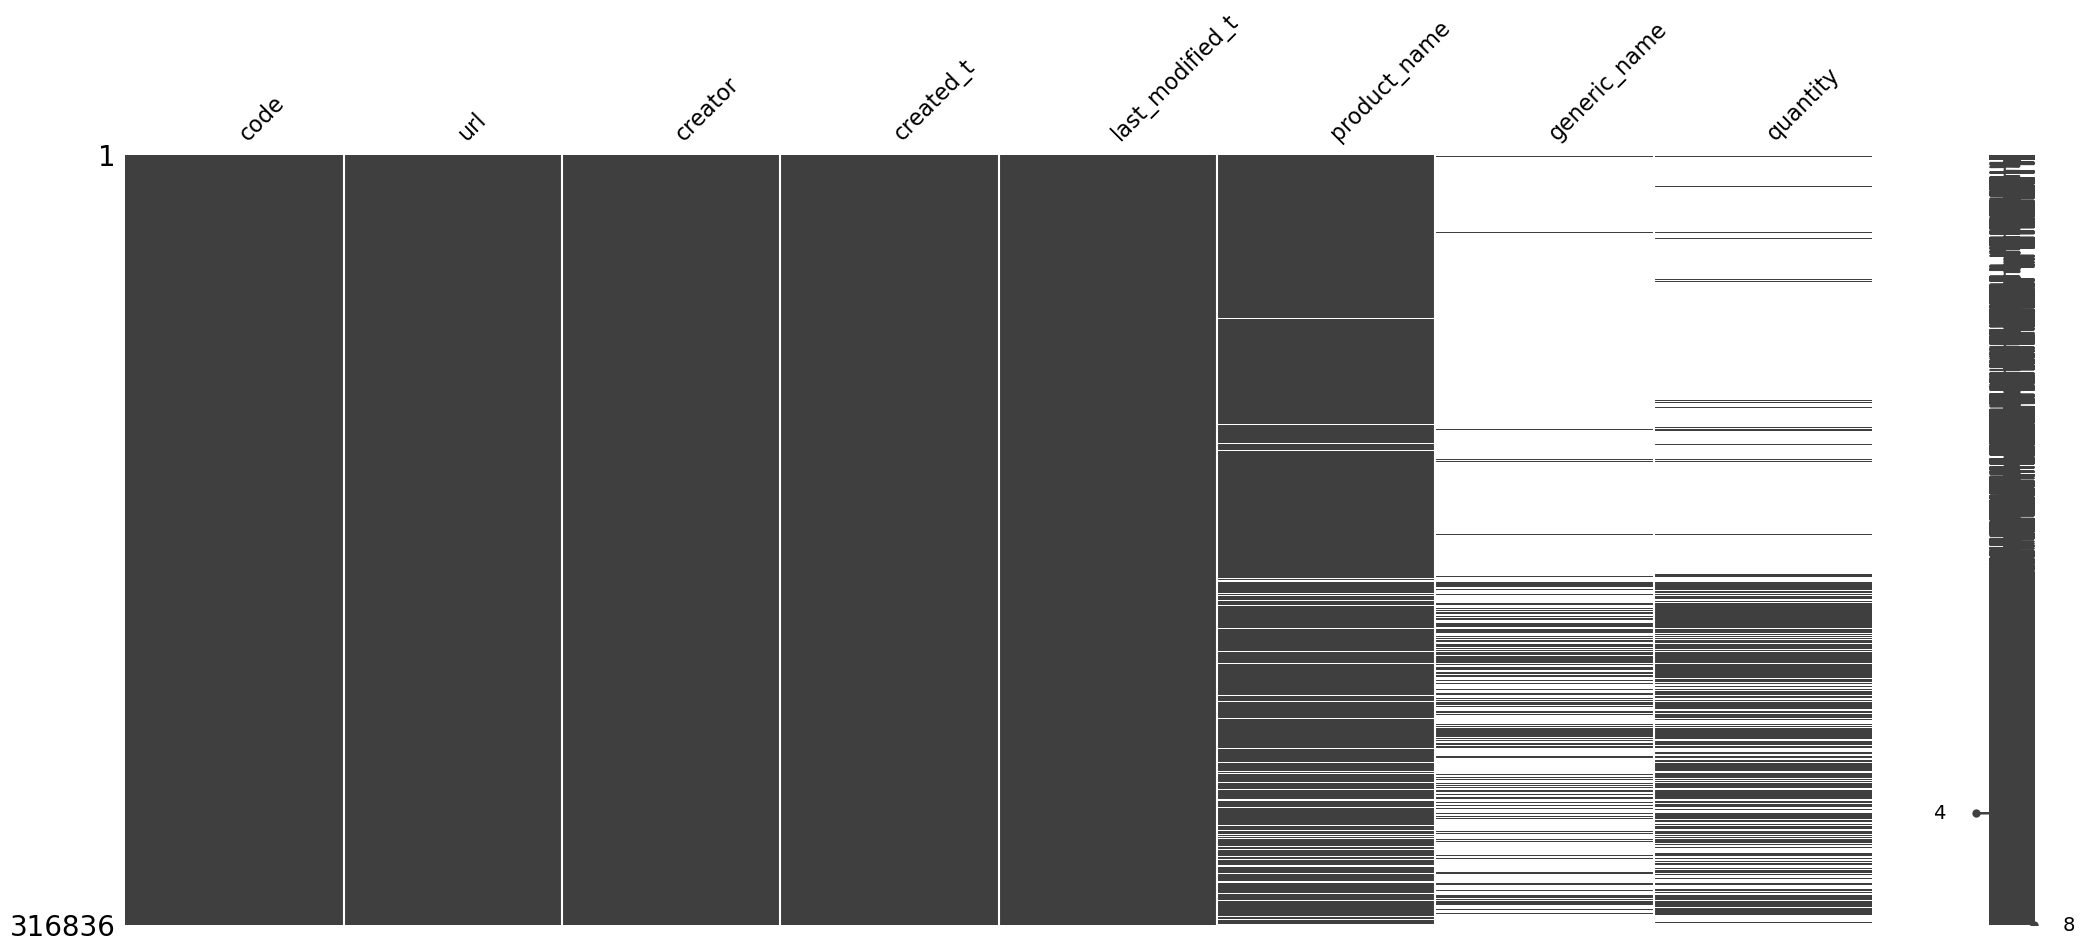

In [38]:
# les variables general_information
msno.matrix(data_cleaned.loc[:,data_cleaned.columns[data_cleaned.columns.isin(general_information)]]);

En s'appuyant sur ce graphique, on supprimera les colonnes qui ne sont pas en lien avec notre projet et les colonnes moins bien renseignées.

In [39]:
# general_information
col_to_drop += ['generic_name','url','creator', 'created_t', 'last_modified_t']
colgarder += ['code','product_name','quantity']

#Maj general_information
[general_information.remove(x) for x in col_to_drop]
general_information

['code', 'product_name', 'quantity']

</br>

</br>

</br>

</br>

</br>

</br>

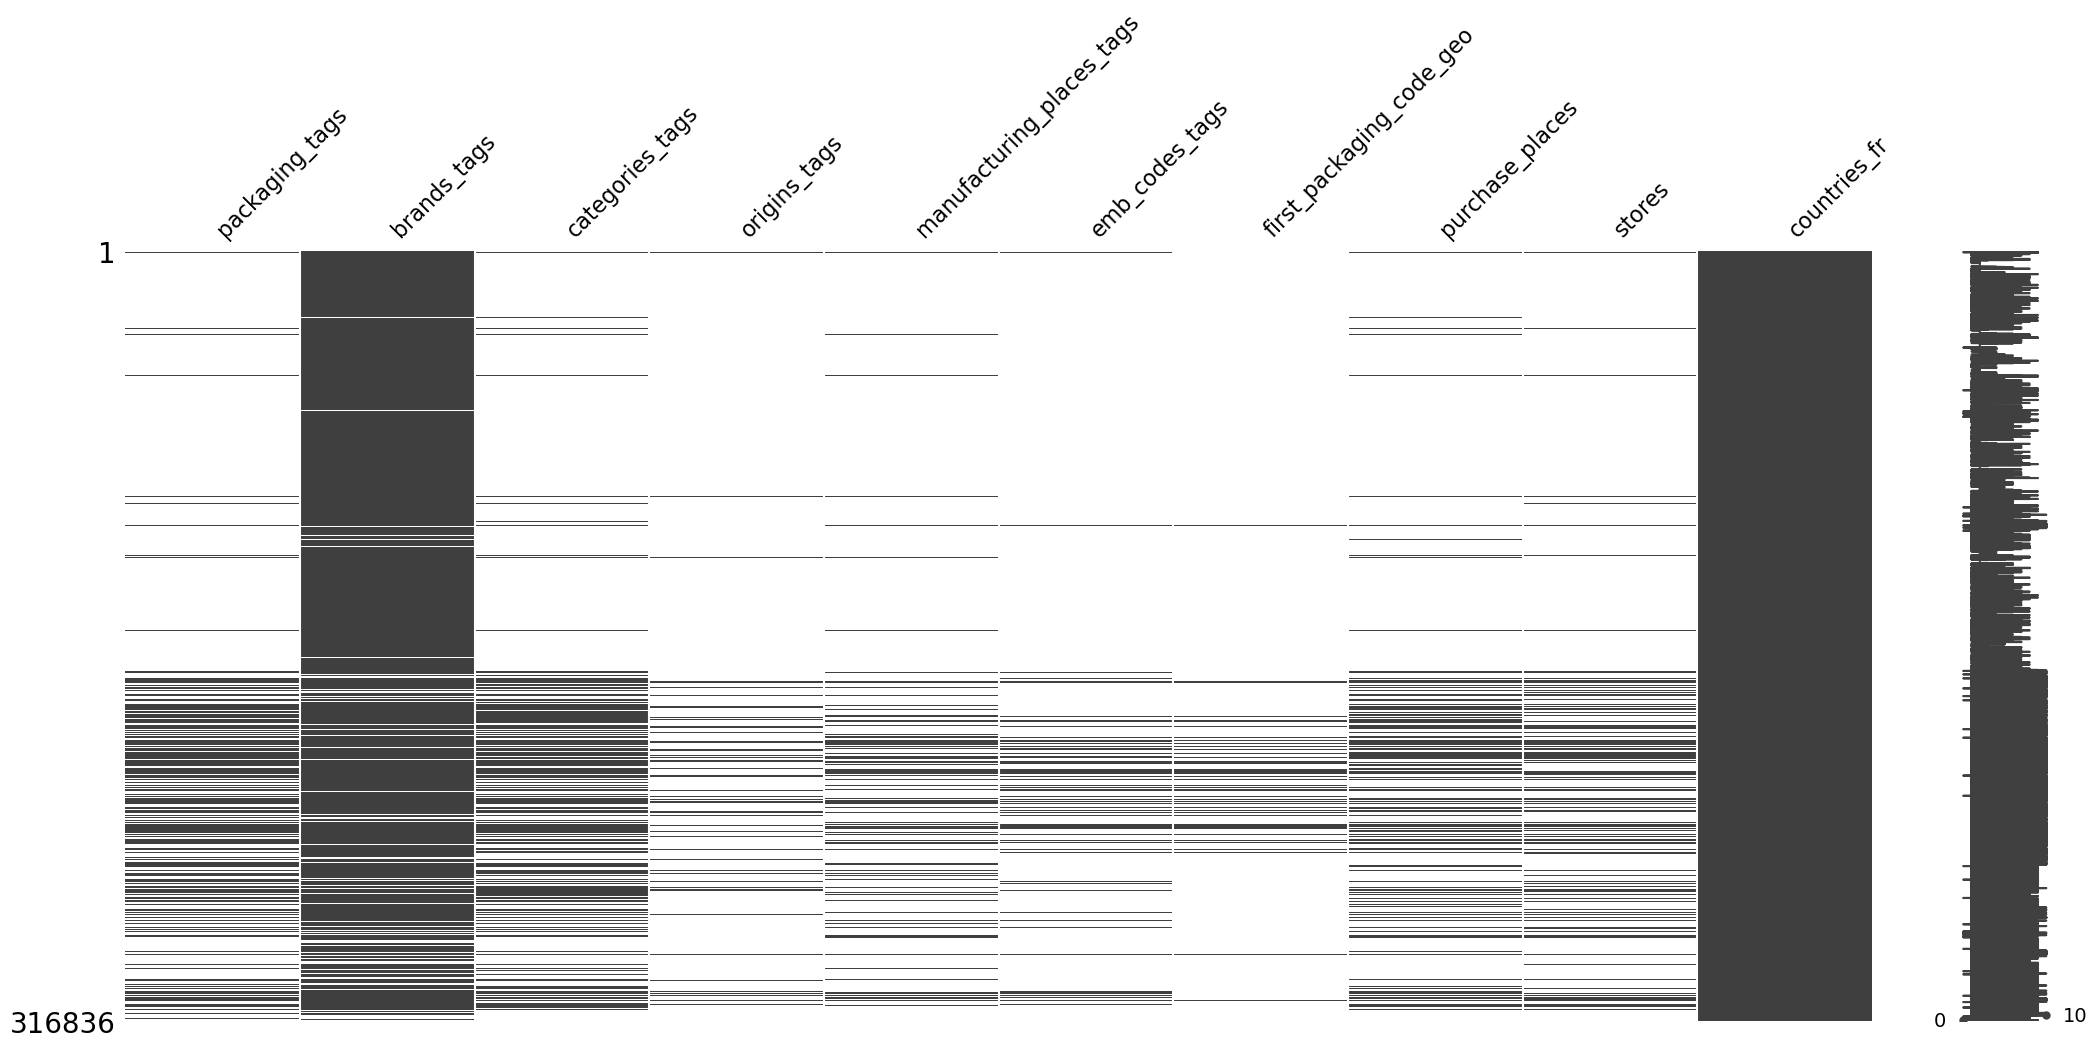

In [40]:
# les variables tags
msno.matrix(data_cleaned.loc[:,data_cleaned.columns[data_cleaned.columns.isin(tags)]]);

In [41]:
data_cleaned.loc[:,data_cleaned.columns[data_cleaned.columns.isin(tags)]].isna().sum()/nbLigne

packaging_tags               0.751714
brands_tags                  0.088576
categories_tags              0.734522
origins_tags                 0.930507
manufacturing_places_tags    0.885262
emb_codes_tags               0.907709
first_packaging_code_geo     0.940736
purchase_places              0.817126
stores                       0.837462
countries_fr                 0.000846
dtype: float64

Les colonnes categories_fr, main_categorie et categories_fr sont renseignées de façon presque identiques.</br>
Les produits ne possédant dinfos pour la variables categories ne possedent pas d'infos pour la variables main_category</br>
Nous conservons pour l'instant 'categories_tags' pour la comparer plus tard avec les autres colonnes définissant la catégorie

In [42]:
# tags
col_to_drop += [ 'packaging_tags','brands_tags',
                'origins_tags','manufacturing_places_tags', 
                'emb_codes_tags','first_packaging_code_geo',
                'purchase_places','stores','countries_fr',
                #'cities',
                #'cities_tags','countries','countries_tags',
                #'emb_codes', 
                #'categories','categories_tags'              
                 ]

colgarder.append('categories_tags')


#Maj tags
[tags.remove(x) for x in [ 'packaging_tags','brands_tags', 
                'origins_tags','manufacturing_places_tags', 
                'emb_codes_tags','first_packaging_code_geo',
                'purchase_places','stores','countries_fr',]]
tags

['categories_tags']

</br>

</br>

</br>

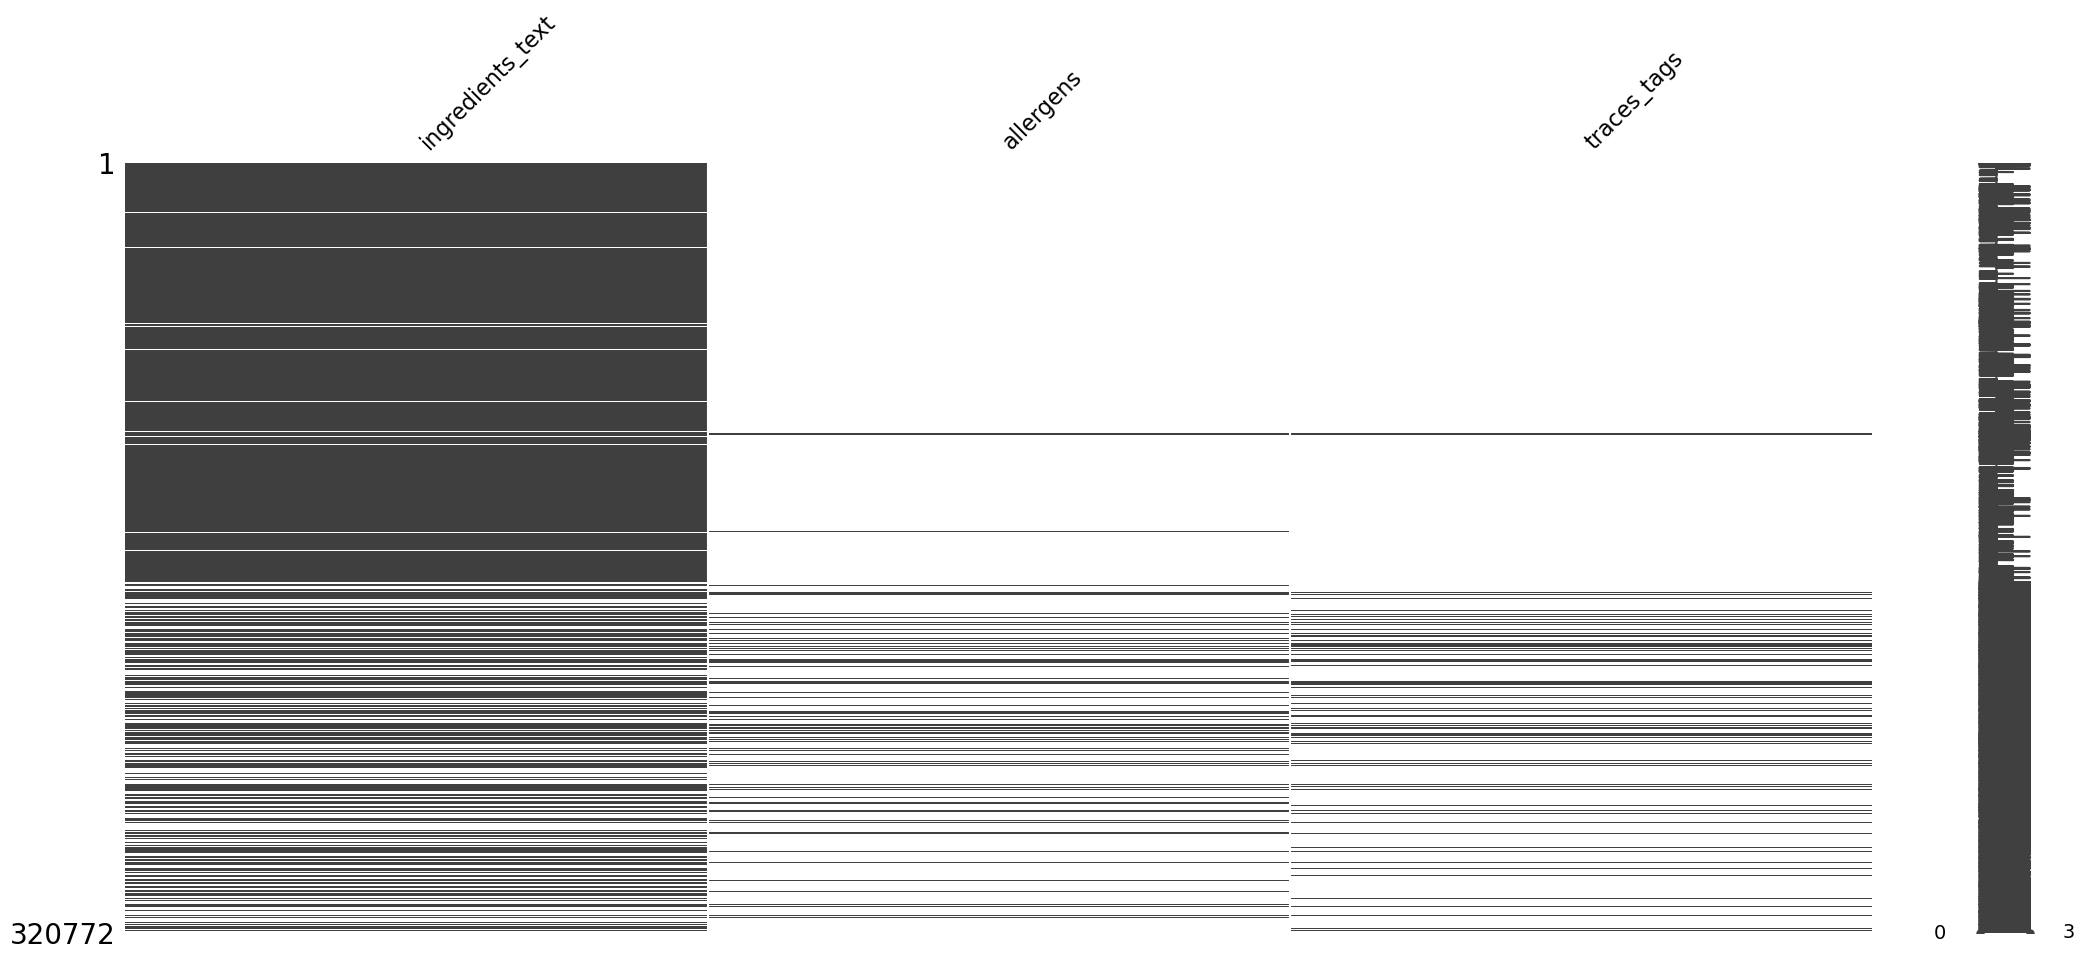

In [43]:
#les variables ingredients
msno.matrix(openfoodfacts.loc[:,openfoodfacts.columns[openfoodfacts.columns.isin(ingredients)]]);

In [44]:
data_cleaned[ingredients].notna().sum()/nbLigne

ingredients_text    0.774495
allergens           0.089210
traces_tags         0.076522
dtype: float64

In [45]:
data_cleaned[ingredients].nunique()

ingredients_text    203370
allergens            12888
traces_tags           3564
dtype: int64

On voit que les colonnes allergens et traces_tags sont presque totalement vides.</br>
Cependant la colonne ingredients_text possèdent 205515 modalités uniques différentes.</br>
Aucunes colonnes ne sera conservées

In [46]:
# ingredients
col_to_drop += ['ingredients_text','allergens', 'traces_tags']
#colgarder += ['ingredients_text']

#Maj tags
[ingredients.remove(x) for x in [ 'ingredients_text','allergens', 'traces_tags']]
ingredients

[]

</br>

</br>

</br>

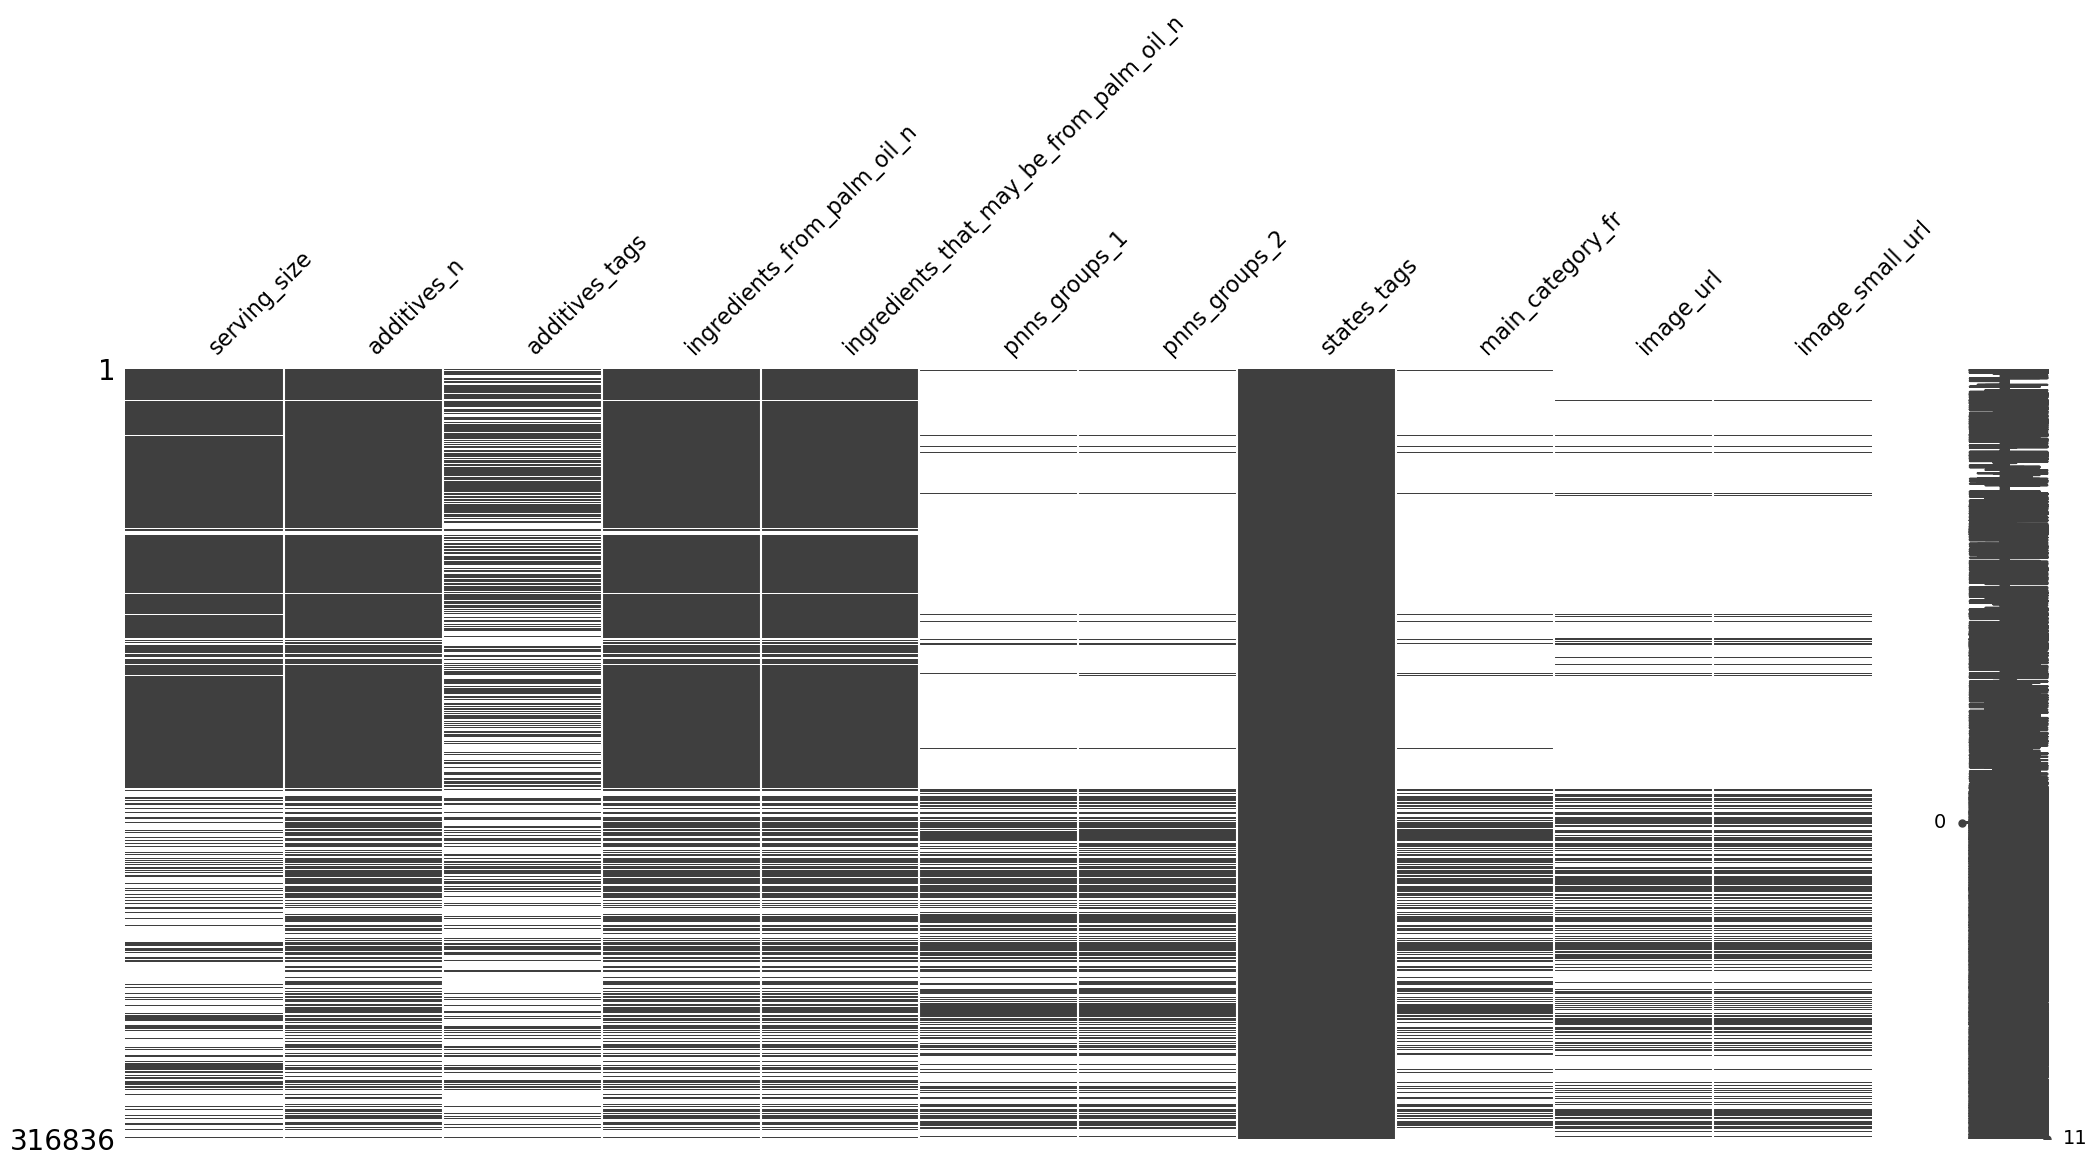

In [47]:
#les variables misc_data
msno.matrix(data_cleaned.loc[:,data_cleaned.columns[data_cleaned.columns.isin(misc_data)]]);

In [48]:
pd.set_option('max_colwidth', None)
data_cleaned[['pnns_groups_1','pnns_groups_2','categories_tags','main_category_fr']].notna().sum()/nbLigne

pnns_groups_1       0.287802
pnns_groups_2       0.297166
categories_tags     0.265478
main_category_fr    0.265405
dtype: float64

In [49]:
data_cleaned[['pnns_groups_1','pnns_groups_2','categories_tags','main_category_fr']].nunique()

pnns_groups_1          14
pnns_groups_2          42
categories_tags     21070
main_category_fr     3520
dtype: int64

Les colonnes qui fournissent des informations sur le groupes (ou la catégory) de l'aliment possèdent le même nombre de valeurs manquantes.</br>
Cependant le nombre de modalités uniques est different. </br>
les colonnes pnns_groups 1 & 2 sont les plus interressantes.

In [50]:
data_cleaned[['pnns_groups_1','pnns_groups_2']].drop_duplicates().sort_values('pnns_groups_1')

,pnns_groups_1,pnns_groups_2
10316,Beverages,Artificially sweetened beverages
10358,Beverages,Fruit juices
65421,Beverages,Fruit nectars
226,Beverages,Sweetened beverages
188,Beverages,Non-sugared beverages
628,Cereals and potatoes,Cereals
9779,Cereals and potatoes,Breakfast cereals
23712,Cereals and potatoes,Potatoes
177,Cereals and potatoes,Bread
182,Cereals and potatoes,Legumes


In [51]:
# unknown
data_cleaned.loc[data_cleaned['pnns_groups_2']=='unknown','pnns_groups_2'] = np.nan
data_cleaned.loc[data_cleaned['pnns_groups_1']=='unknown','pnns_groups_1'] = np.nan

# remplacer les '-' par ' ' et transformer toutes valeurs en minuscules
data_cleaned.pnns_groups_2 = data_cleaned.pnns_groups_2.str.replace('-',' ',regex=True).str.lower()
data_cleaned.pnns_groups_1 = data_cleaned.pnns_groups_1.str.replace('-',' ',regex=True).str.lower()

<AxesSubplot:title={'center':'Camember pnns_groups_2'}>

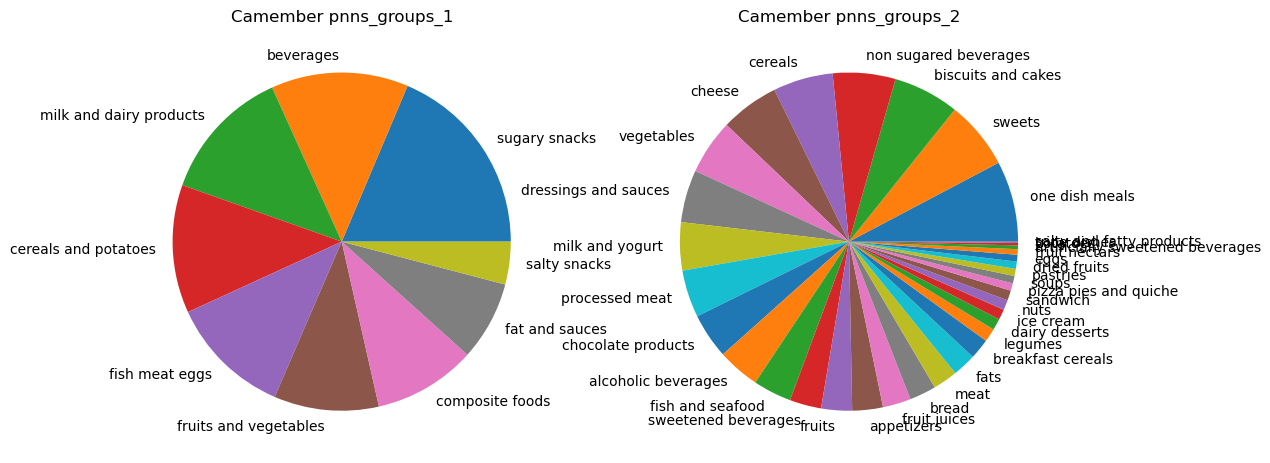

In [52]:
# pie plot
fig, axes = plt.subplots(nrows=1, ncols=2,  figsize=(12, 6))

axes[0].set_title('Camember pnns_groups_1')
data_cleaned.pnns_groups_1.value_counts().plot(kind='pie',ax =  axes[0],label = '')
axes[0].xaxis.label.set_color('red')
axes[1].set_title('Camember pnns_groups_2')
data_cleaned.pnns_groups_2.value_counts().plot(kind='pie',ax =  axes[1],label = '')

In [53]:
# misc_data
col_to_drop += ['additives_n','additives_tags','states_tags','ingredients_from_palm_oil_n',
                'ingredients_that_may_be_from_palm_oil_n', 'main_category_fr',
                'image_url', 'image_small_url']


colgarder += ['serving_size', 'pnns_groups_1', 'pnns_groups_2']

#Maj tags
[misc_data.remove(x) for x in ['additives_n','additives_tags','states_tags','ingredients_from_palm_oil_n',
                'ingredients_that_may_be_from_palm_oil_n', 'main_category_fr',
                'image_url', 'image_small_url']]
misc_data

['serving_size', 'pnns_groups_1', 'pnns_groups_2']

</br>

</br>

</br>

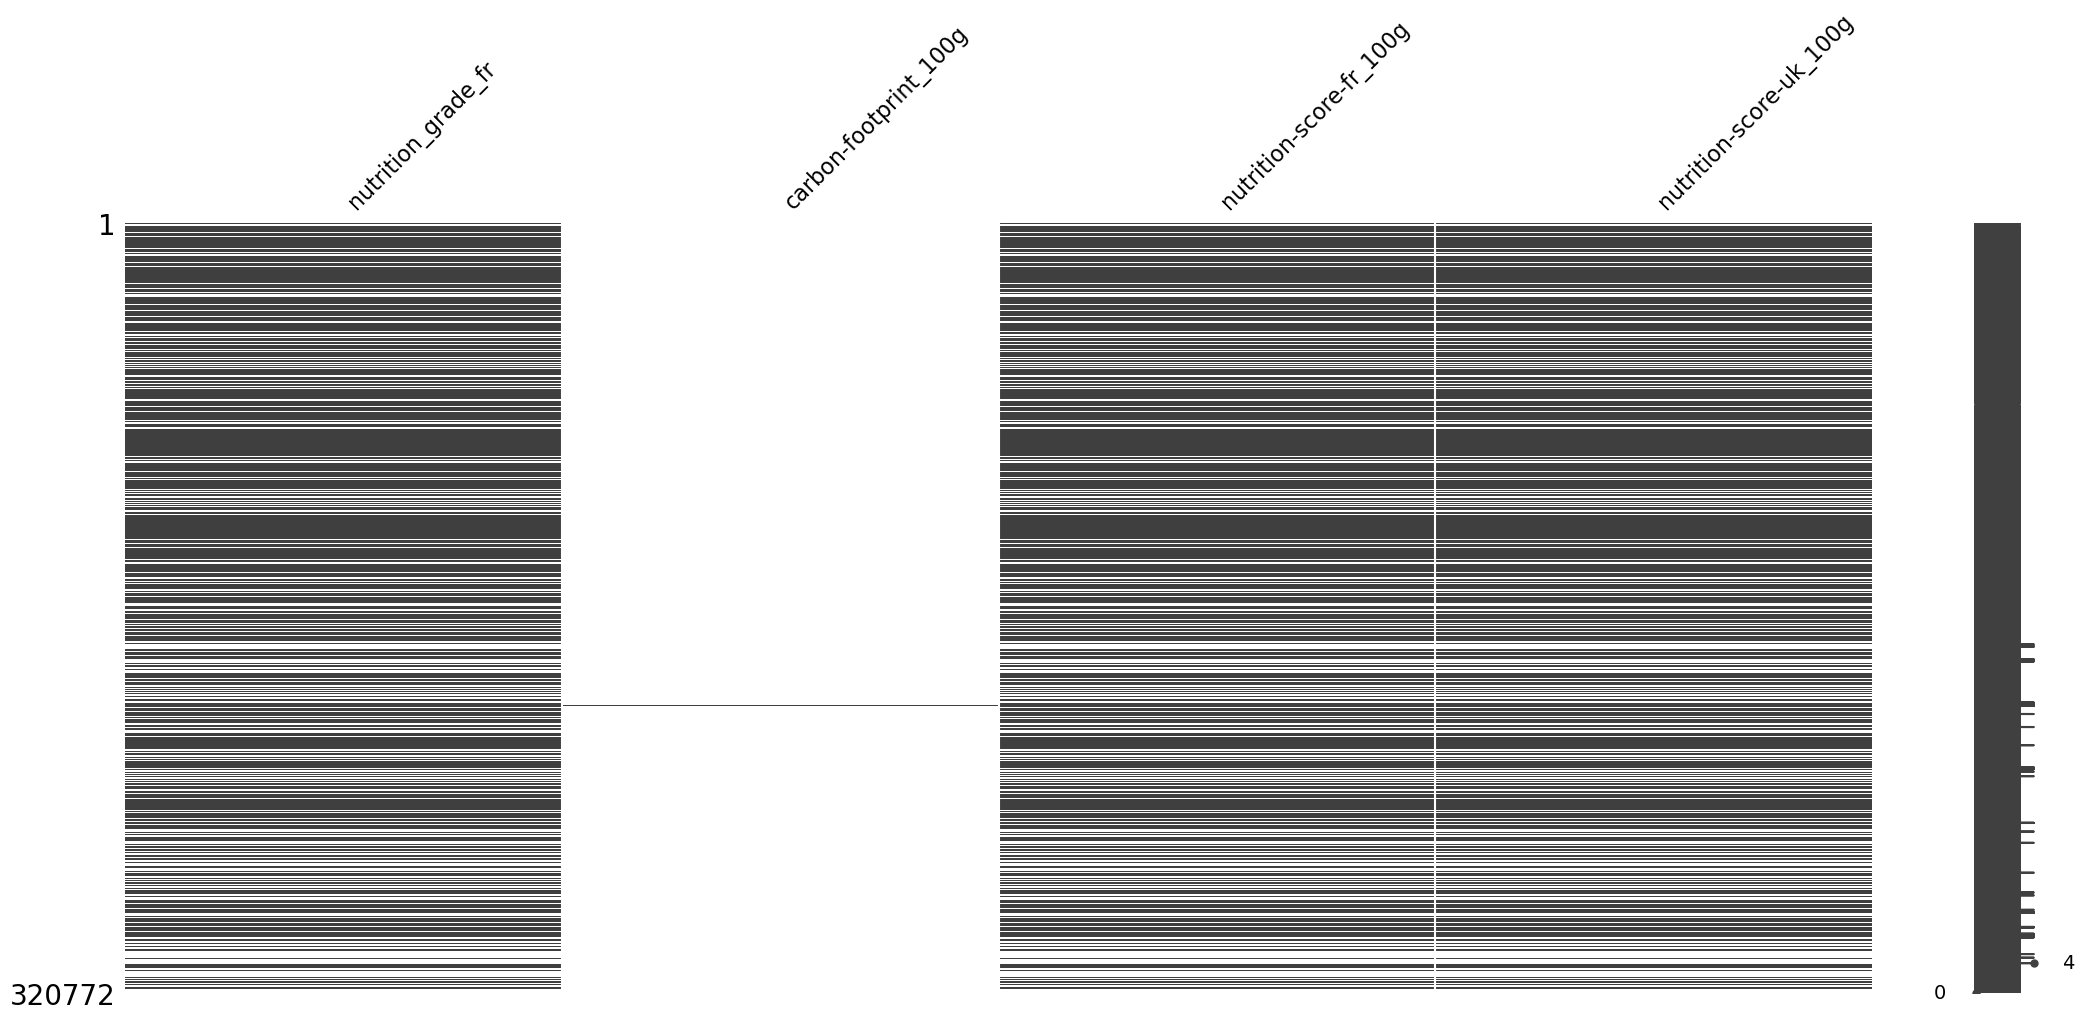

In [54]:
# les variables score_foot_print
msno.matrix(openfoodfacts.loc[:,data_cleaned.columns[data_cleaned.columns.isin(score_foot_print)]]);

In [55]:
data_cleaned.loc[:,data_cleaned.columns[data_cleaned.columns.isin(score_foot_print)]].isna().sum()/nbLigne

nutrition_grade_fr         0.310419
carbon-footprint_100g      0.999157
nutrition-score-fr_100g    0.310419
nutrition-score-uk_100g    0.310419
dtype: float64

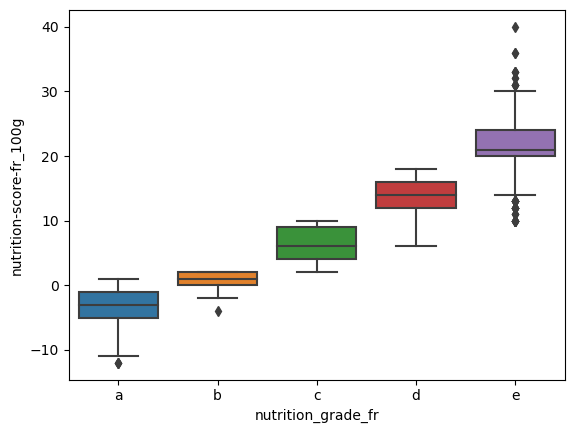

In [56]:
#data_cleaned[[ 'nutrition-score-fr_100g', 'data_cleaned.nutrition_grade_fr']].boxplot()
sns.boxplot(y='nutrition-score-fr_100g',
            x='nutrition_grade_fr',
            data=openfoodfacts.sample(10000).sort_values(by='nutrition_grade_fr'));

On voit bien qu'il existe une liaison entre le nutrition_grade_fr et le nutrition-score-fr_100g.</br>
On s'aperçoit que d'autres informations rentrent en compte dans le calcul du nutrigrade.

In [57]:
# score_foot_print
col_to_drop += ['nutrition_grade_uk','carbon-footprint_100g', 'nutrition-score-uk_100g']

colgarder += ['nutrition_grade_fr', 'nutrition-score-fr_100g']

#Maj tags
[score_foot_print.remove(x) for x in ['nutrition_grade_uk','carbon-footprint_100g', 'nutrition-score-uk_100g']]
score_foot_print

['nutrition_grade_fr', 'nutrition-score-fr_100g']

</br>

</br>

</br>

In [58]:
# la variable labels

In [59]:
data_cleaned[data_cleaned.labels_tags.notna()][labels].describe()

,labels_tags
count,46472
unique,13607
top,"en:organic,en:eu-organic,fr:ab-agriculture-biologique"
freq,5304


</br>

In [60]:
# labels

# Variables à supprimer
col_to_drop += ['labels_tags']

</br>

</br>

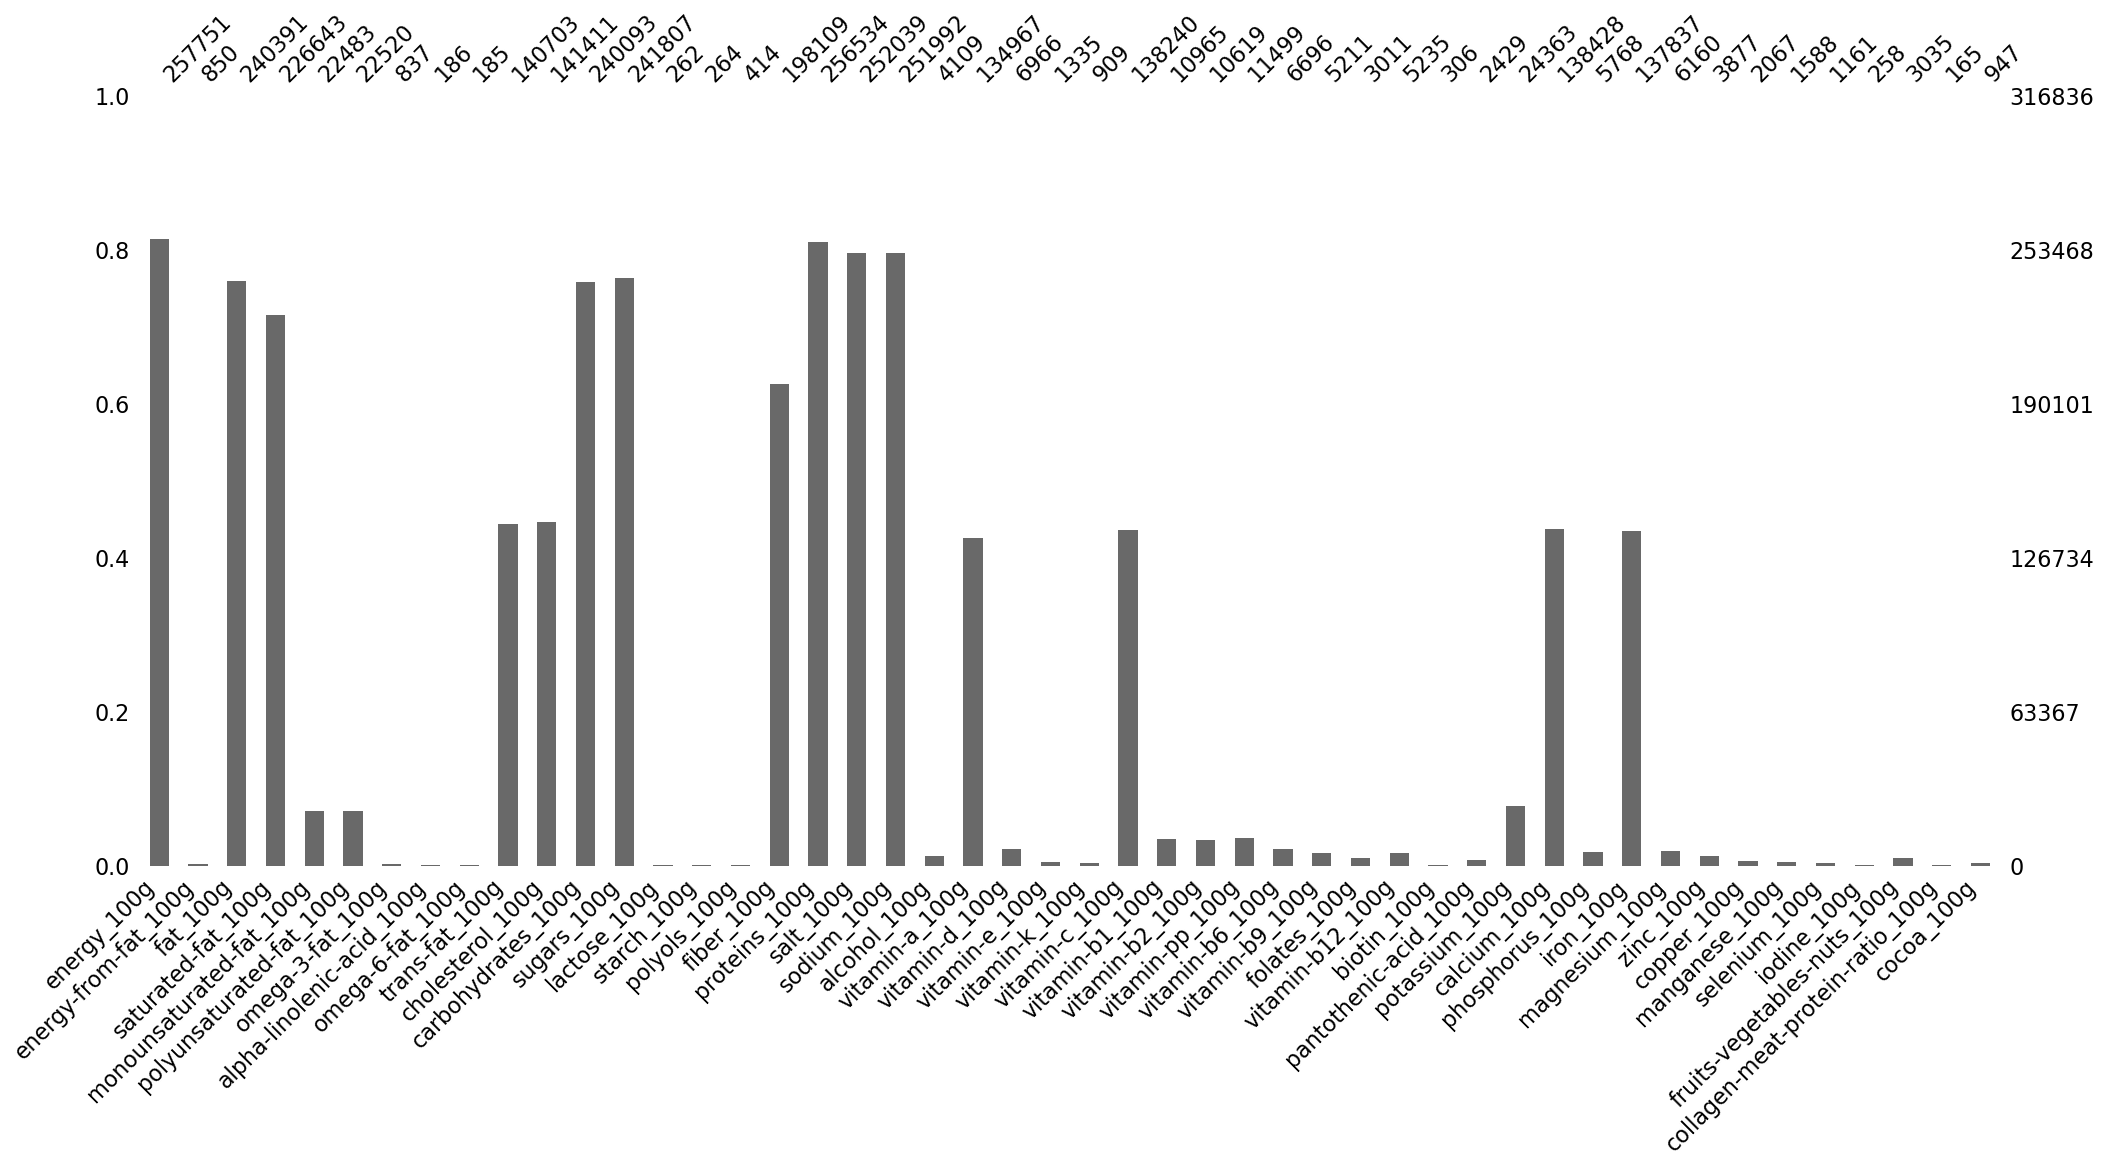

In [61]:
# nutrition_facts
msno.bar(data_cleaned.loc[:,nutrition_facts ]);

In [62]:
pd.DataFrame(data_cleaned.loc[:,data_cleaned.columns[data_cleaned.columns.isin(nutrition_facts)] ].isna().sum()/nbLigne).T\
.style.background_gradient(cmap='Blues').format("{:.2%}")

,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,alpha-linolenic-acid_100g,omega-6-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,lactose_100g,starch_100g,polyols_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,potassium_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,selenium_100g,iodine_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g
0,18.65%,99.73%,24.13%,28.47%,92.90%,92.89%,99.74%,99.94%,99.94%,55.59%,55.37%,24.22%,23.68%,99.92%,99.92%,99.87%,37.47%,19.03%,20.45%,20.47%,98.70%,57.40%,97.80%,99.58%,99.71%,56.37%,96.54%,96.65%,96.37%,97.89%,98.36%,99.05%,98.35%,99.90%,99.23%,92.31%,56.31%,98.18%,56.50%,98.06%,98.78%,99.35%,99.50%,99.63%,99.92%,99.04%,99.95%,99.70%


In [63]:
nomColonnes

,Colonnes,type_de_colonne,Taux de valeurs non nulles,Nombre de valeurs manquantes
0,code,general_information,100.00,0
1,url,general_information,100.00,0
2,creator,general_information,100.00,2
3,created_t,general_information,100.00,0
4,last_modified_t,general_information,100.00,0
5,product_name,general_information,94.43,17635
6,generic_name,general_information,16.59,264271
7,quantity,general_information,32.96,212393
8,packaging_tags,tags,24.83,238170
9,brands_tags,tags,91.14,28064


Au total le jeu de données contient 48 colonnes contenant des informations sur les valeurs nutritives. 
Parmi ces colonnes, 33 sont composées de plus de 60% de valeurs manquantes


''

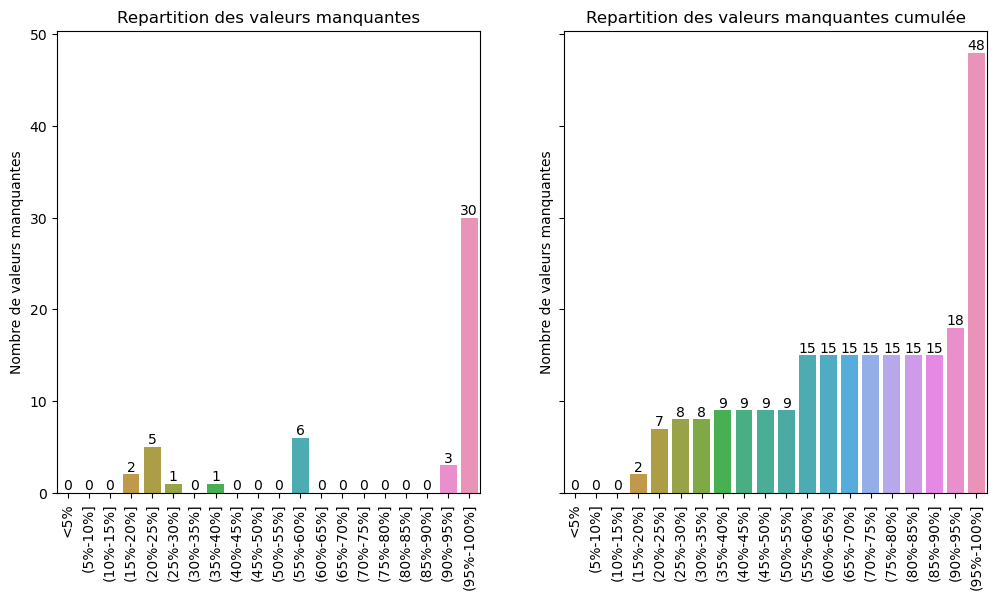

In [64]:
threshold_ = 0.6
print('Au total le jeu de données contient {} colonnes contenant des informations sur les valeurs nutritives. \nParmi ces colonnes, {} sont composées de plus de {pourc:.0%} de valeurs manquantes'
      .format((nomColonnes.type_de_colonne=='nutrition_facts').sum(),
              (data_cleaned.loc[:,data_cleaned.columns[data_cleaned.columns.isin(nutrition_facts)] ].isna().sum()>=nbLigne*threshold_).sum(),pourc=threshold_
              ))

nbin = 20
interbin = 100/nbin

xlab = ['<{:.0f}%'.format(interbin) if i==0 else '({:.0f}%-{:.0f}%]'.format(i*interbin,(i+1)*interbin) for i in range(nbin)]
ycut = pd.cut(nomColonnes[nomColonnes.type_de_colonne=='nutrition_facts']['Nombre de valeurs manquantes']/nbLigne, 
                     [ i/nbin for i in range(nbin+1)], # ajoute 1 pour obtenir la derniere tranche
                     include_lowest=False).value_counts().sort_index()

fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(12, 6))

axes[0].set_title('Repartition des valeurs manquantes')
sns.barplot(x=ycut.index, y=ycut,ax=axes[0] )
axes[0].set_xticks(range(nbin))   # Attention cette fois on ajoute pas +1
axes[0].set_xticklabels(xlab, rotation=90)
axes[0].bar_label(axes[0].containers[0])

axes[1].set_title('Repartition des valeurs manquantes cumulée')
sns.barplot(x=ycut.index, y=ycut.cumsum(),ax=axes[1] )
axes[1].set_xticks(range(nbin))# Attention cette fois on ajoute pas +1
axes[1].set_xticklabels(xlab, rotation=90)
axes[1].bar_label(axes[1].containers[0])

;

In [65]:
# nutrition_facts

print('le seuil ',threshold_)
for col,typc,nNa in zip(nomColonnes.Colonnes,
                        nomColonnes.type_de_colonne,
                        nomColonnes['Nombre de valeurs manquantes']) :
    if typc =='nutrition_facts':
        if (nNa >= (nbLigne * threshold_)) & (col not in ['energy_100g', 'sugars_100g', 'saturated-fat_100g','sodium_100g', 'fiber_100g', 'proteins_100g','fruits-vegetables-nuts_100g']):
            # suppr col qui possèdent 95% de valeurs nulles
            # sauf les colonnes qui rentre en compte dans le calcul du nutriscore
            col_to_drop.append(col)
        else:
            colgarder.append(col)

le seuil  0.6


In [66]:
colgarder

['code',
 'product_name',
 'quantity',
 'categories_tags',
 'serving_size',
 'pnns_groups_1',
 'pnns_groups_2',
 'nutrition_grade_fr',
 'nutrition-score-fr_100g',
 'energy_100g',
 'fat_100g',
 'saturated-fat_100g',
 'trans-fat_100g',
 'cholesterol_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'fiber_100g',
 'proteins_100g',
 'salt_100g',
 'sodium_100g',
 'vitamin-a_100g',
 'vitamin-c_100g',
 'calcium_100g',
 'iron_100g',
 'fruits-vegetables-nuts_100g']

In [67]:
print('Parmi les {} colonnes, nous en supprimons {} et gardons {}'.format(nbCol,len(col_to_drop),len(colgarder) ) )

Parmi les 85 colonnes, nous en supprimons 61 et gardons 25


<AxesSubplot:>

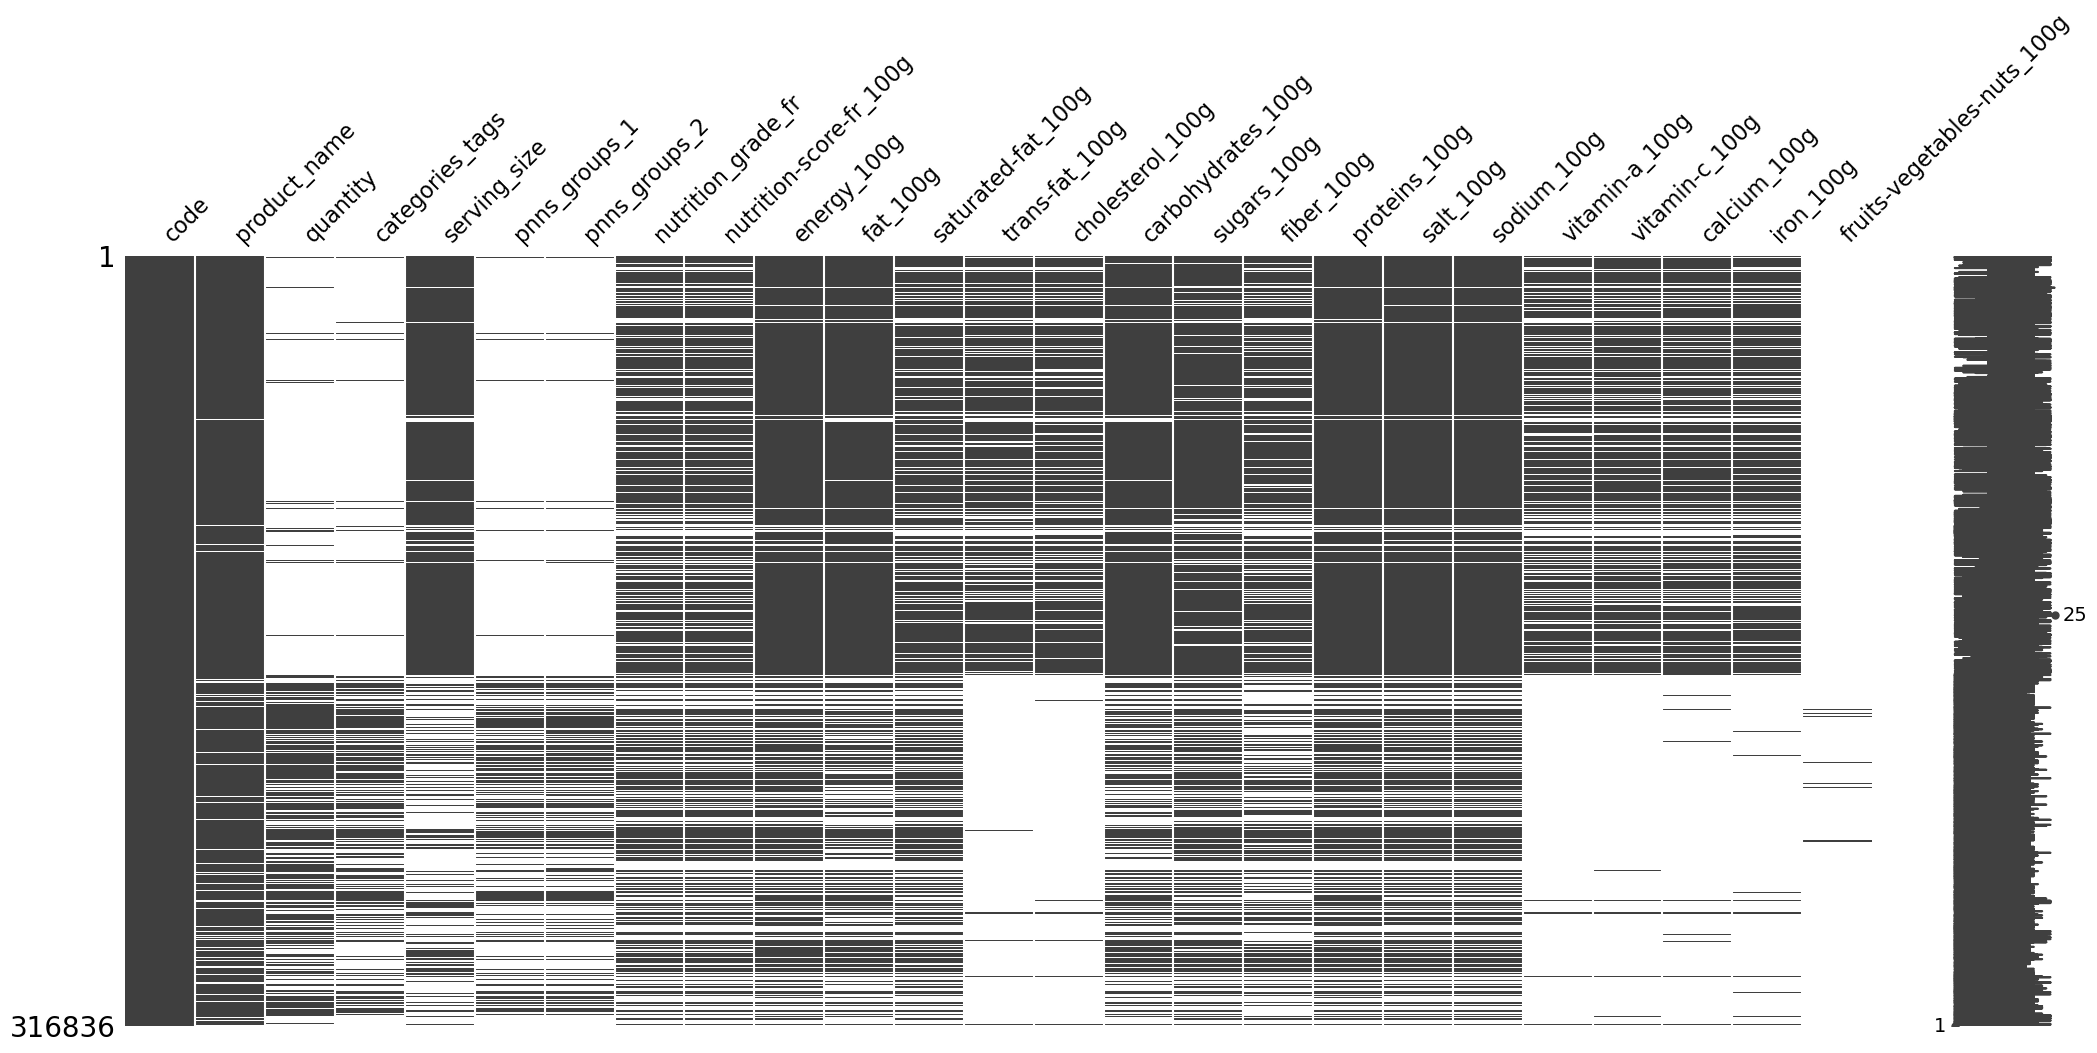

In [68]:
msno.matrix(data_cleaned[colgarder])

In [69]:
# A-t-on oublié certaines colonnes
listOublie = [x  for x in data_cleaned.columns if x not in col_to_drop+colgarder ]
print('Combien de variables ont été oubliées: ',len(listOublie) )
del listOublie

Combien de variables ont été oubliées:  0


</br>

## Etude des correlations

In [70]:
data_cleaned[colgarder].corr()\
.style.background_gradient(cmap = sns.color_palette("blend:red,green", as_cmap=True),axis=None)

,nutrition-score-fr_100g,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,fruits-vegetables-nuts_100g
nutrition-score-fr_100g,1.000000,0.067342,0.567028,0.623702,0.021910,0.035663,0.264248,0.441686,-0.046669,0.107742,0.007277,0.007277,-0.006531,-0.010120,0.017126,-0.001394,-0.293811
energy_100g,0.067342,1.000000,0.093792,0.073409,0.021516,0.006446,0.060688,0.056765,0.077377,0.044489,-0.000570,-0.000570,0.000545,-0.004311,0.007117,0.003814,-0.263160
fat_100g,0.567028,0.093792,1.000000,0.689012,0.024910,0.025519,-0.088390,-0.047407,0.136037,0.228376,-0.004321,-0.004322,0.002238,-0.009310,0.009671,-0.002663,-0.271507
saturated-fat_100g,0.623702,0.073409,0.689012,1.000000,0.013126,0.050304,-0.050906,0.157192,0.155906,0.165618,-0.002206,-0.002207,0.005034,-0.009687,0.020455,-0.003936,-0.272467
trans-fat_100g,0.021910,0.021516,0.024910,0.013126,1.000000,-0.000462,0.006366,0.003389,-0.000784,-0.010063,-0.000145,-0.000145,-0.001924,-0.001703,-0.000738,0.002609,nan
cholesterol_100g,0.035663,0.006446,0.025519,0.050304,-0.000462,1.000000,-0.041824,-0.019727,-0.027843,0.055647,0.131993,0.131993,0.004221,-0.000816,0.005452,-0.000154,-0.359489
carbohydrates_100g,0.264248,0.060688,-0.088390,-0.050906,0.006366,-0.041824,1.000000,0.660890,0.280754,-0.088131,-0.000941,-0.000943,-0.003980,0.003839,-0.010220,0.008821,-0.034533
sugars_100g,0.441686,0.056765,-0.047407,0.157192,0.003389,-0.019727,0.660890,1.000000,0.346275,-0.210048,0.000462,0.000461,-0.014294,0.002665,-0.004242,0.007810,0.152506
fiber_100g,-0.046669,0.077377,0.136037,0.155906,-0.000784,-0.027843,0.280754,0.346275,1.000000,0.192620,-0.000023,-0.000025,0.057589,0.008371,0.001204,0.010982,-0.028287
proteins_100g,0.107742,0.044489,0.228376,0.165618,-0.010063,0.055647,-0.088131,-0.210048,0.192620,1.000000,-0.002273,-0.002274,0.004362,-0.006974,0.042334,0.004017,-0.340760


#### Les matieres grasses

In [71]:
data_cleaned[['fat_100g', 'saturated-fat_100g','trans-fat_100g']].notna().sum()/data_cleaned.shape[0]

fat_100g              0.758724
saturated-fat_100g    0.715332
trans-fat_100g        0.444088
dtype: float64

In [72]:
colgarder.remove("fat_100g")
colgarder.remove('trans-fat_100g')
col_to_drop.extend(['fat_100g','trans-fat_100g'])

</br>

#### le sel et le sodium

In [73]:
saltSodiumX = data_cleaned[['salt_100g' , 'sodium_100g']].dropna()
a = round(saltSodiumX.cov().iloc[0,1]/(saltSodiumX.cov().iloc[1,1]),4)
b = round(saltSodiumX.salt_100g.mean()- a*saltSodiumX.sodium_100g.mean(),4)

a,b
del a,b

(2.54, 0.0)

La formule:
$Y_{salt-100g} = 2.54 * X_{sodium-100g}$

In [74]:
compute_nb_mising_values(data_cleaned[['salt_100g', 'sodium_100g']])
#.notna().sum()

,Taux de valeurs non nulles,Nombre de valeurs manquantes
salt_100g,79.55,64797
sodium_100g,79.53,64844


In [75]:
colgarder.remove("salt_100g")
col_to_drop.extend(['salt_100g'])

</br>

#### Les glucides

Les colonnes, sugars_100g, carbohydrates_100g sont tres corrélés. De plus carbohydrates_100g et sugars_100g ne sont pas independantes.
La variable sugars_100g appartient à la grande famille de carbohydrates_100g (glucide) donc carbohydrates_100g>=sugars_100g

In [76]:
data_cleaned[['sugars_100g', 'carbohydrates_100g']].notna().sum()/data_cleaned.shape[0]

sugars_100g           0.763193
carbohydrates_100g    0.757783
dtype: float64

In [77]:
colgarder.remove("carbohydrates_100g")
col_to_drop.extend(['carbohydrates_100g'])

</br>

#### etude des unités de mesure

L'unité de mesure des portions nous informe sur la consistance de l'aliment ainsi que sur sa composition.

In [78]:
data_cleaned[['code','product_name','quantity','serving_size']].sample(5)

,code,product_name,quantity,serving_size
69523,0070227601809,Soup Croutons,NaN,30 g (30 g)
155445,0837186006331,Organic Green Lentil Penne,NaN,85 g (3 ONZ)
64823,0052742211909,NaN,NaN,NaN
47321,0041415310865,English Peas,NaN,73 g (2.5 OZ)
192847,3083681002416,Maizbio,100 g,NaN


In [79]:
etude_test = data_cleaned[data_cleaned.columns[(~data_cleaned.columns.isin(nutrition_facts)) & (data_cleaned.columns.isin(colgarder))]]\
.drop(columns=['code','product_name']).copy()

In [80]:
etude_test.columns

Index(['quantity', 'categories_tags', 'serving_size', 'nutrition_grade_fr',
       'pnns_groups_1', 'pnns_groups_2', 'nutrition-score-fr_100g'],
      dtype='object')

In [81]:
etude_test.serving_size[etude_test.serving_size.notna()].str.lower().str.replace('\\(.+[^(]\\)','',regex=True)\
.str.replace('[0-9]','',regex=True)\
.str.replace('[\\,\\*\\. ]','',regex=True)\
.str.replace(' ','',regex=True).value_counts().index[:5].to_list()+etude_test.quantity[etude_test.quantity.notna()].str.lower().str.replace('\\(.+[^(]\\)','',regex=True)\
.str.replace('[0-9]','',regex=True)\
.str.replace('[\\,\\*\\. ]','',regex=True)\
.str.replace(' ','',regex=True).value_counts().index[:10].to_list()

['g',
 'ml',
 'cl',
 'l',
 '',
 'g',
 'l',
 'ml',
 'cl',
 'kg',
 '',
 'gr',
 'oz',
 'xg',
 'ge']

In [82]:
data_cleaned[['quantity','url','serving_size']][etude_test.quantity.str.lower().str.replace('\\(.+[^(]\\)','',regex=True)\
.str.replace('[0-9]','',regex=True)\
.str.replace('[\\,\\*\\. ]','',regex=True)\
.str.replace(' ','',regex=True)=='xg'].sample(10)

,quantity,url,serving_size
292868,2 x 125 g (250 g),http://world-fr.openfoodfacts.org/produit/7613035495937/tendre-croc-bistrot-a-la-bechamel-jambon-fromage-a-gratiner-herta,125 g
226483,4 x 125 g,http://world-fr.openfoodfacts.org/produit/3339520092651/4-yaourts-a-la-fraise-de-dordogne-pechalou,125g par pot
250893,2 x 150g,http://world-fr.openfoodfacts.org/produit/3701002400641/yaourt-a-la-grecque-la-paturiere,NaN
245766,4 x 125 g,http://world-fr.openfoodfacts.org/produit/3596710340699/bifidus-saveur-vanille-auchan,NaN
189214,12 x 115 g (1380 g),http://world-fr.openfoodfacts.org/produit/3033490907808/danette-aux-3-chocolats-danone,115 g
232972,4 x 125 g,http://world-fr.openfoodfacts.org/produit/3438860001863/yaourts-de-chevre-bio-bernard-gaborit,NaN
292737,2x200g (400g),http://world-fr.openfoodfacts.org/produit/7613035328259/p-tit-souper-douceur-d-artichauts-tomates-macaronis-nestle,200g (un bol)
196185,4 x 160 g,http://world-fr.openfoodfacts.org/produit/3165950216400/thon-entier-au-naturel-cuit-a-coeur-saupiquet,NaN
241874,4x 100g,http://world-fr.openfoodfacts.org/produit/3564700455241/pomme-peche-abricot-marque-repere,1 pot de 100g
262534,2x190g,http://world-fr.openfoodfacts.org/produit/4062300055995/hipp-biologique-delices-du-jardin-jardiniere-de-legumes,190g


In [83]:
unites = {
    #les liquides
    'l' : 'litre', 'ml': 'litre', 'cl': 'litre', 'litre': 'litre','litres': 'litre',
    'floz': 'litre', 'xcl':'litre','xml': 'litre', 'g/ml':'litre', 'le':'litre',
    
    # les aliments solides (ou mous)
    'kg': 'poids','g' : 'poids', 'gr': 'poids', 'oz': 'poids', 'xg': 'poids',  'ge': 'poids',
    'grammes': 'poids','г': 'poids',  'xg=g': 'poids', 'ozg': 'poids', 'grs': 'poids', 'lb': 'poids',
    
    # ceux qui peuvent etre definis
    'kg[x]': 'petit pot/yaourt', 'gml': 'bocal/conserve', 'mlg':'creme/sauce',
    
    # part ou portion de ensemble plus grand
    'sachets': 'unité','oeufs': 'unité','tranches': 'unité','x': 'unité',
    
}

unitesAbb = [
    #les liquides
    'l' , 'ml', 'cl', 'litre','litres', 'floz', 'xcl','xml', 'g/ml', 'le',
    
    # les aliments solides (ou mous)
    'kg','g' , 'gr', 'oz', 'xg',  'ge', 'grammes','г',  'xg=g', 'ozg', 'grs', 'lb',
    
    # ceux qui peuvent etre definis
    'kg[x]', 'gml', 'mlg',
    
    # part ou portion de ensemble plus grand
    'sachets','oeufs','tranches','x'
]

In [84]:
#creation colonnes unites mini
data_cleaned['unites_abb'] = [y if y in unitesAbb else x if x in unitesAbb else np.nan for x,y in zip(data_cleaned.quantity.str.lower().str.replace('\\(.+[^(]\\)','',regex=True)\
.str.replace('[0-9]','',regex=True)\
.str.replace('[\\,\\*\\. ]','',regex=True)\
.str.replace(' ','',regex=True),
                    data_cleaned.serving_size.str.lower().str.replace('\\(.+[^(]\\)','',regex=True)\
.str.replace('[0-9]','',regex=True)\
.str.replace('[\\,\\*\\. ]','',regex=True)\
.str.replace(' ','',regex=True) )]

#creation colonnes unites
data_cleaned['unites'] = [y if not y is np.nan else x for x,y in zip(data_cleaned.quantity.str.lower().str.replace('\\(.+[^(]\\)','',regex=True)\
.str.replace('[0-9]','',regex=True)\
.str.replace('[\\,\\*\\. ]','',regex=True)\
.str.replace(' ','',regex=True).map(unites),
                    data_cleaned.serving_size.str.lower().str.replace('\\(.+[^(]\\)','',regex=True)\
.str.replace('[0-9]','',regex=True)\
.str.replace('[\\,\\*\\. ]','',regex=True)\
.str.replace(' ','',regex=True).map(unites))]

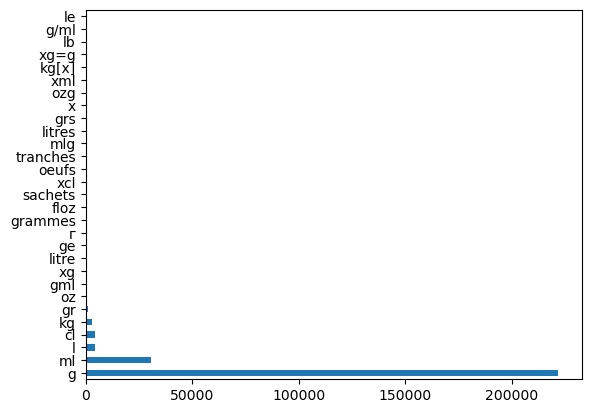

In [85]:
data_cleaned['unites_abb'].value_counts().plot(kind='barh');

<AxesSubplot:>

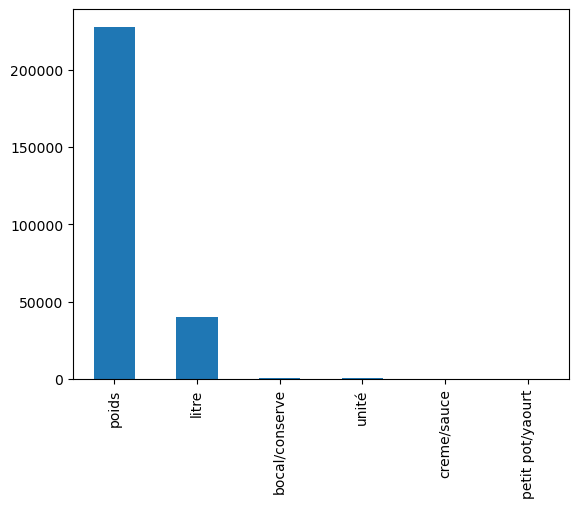

In [86]:
data_cleaned['unites'].value_counts().plot(kind='bar')

In [87]:
# get dummies
data_cleaned[['bocal/conserve','creme/sauce','litre','petit pot/yaourt','poids','unité']] = pd.get_dummies(data_cleaned.unites)
colgarder += ['bocal/conserve','creme/sauce','litre','petit pot/yaourt','poids','unité']
del etude_test,unitesAbb,unites

</br>

</br>

## Gestion des outliers

#### les boxplots

In [88]:
numCol = data_cleaned[colgarder].select_dtypes(include=[np.number]).columns.tolist()

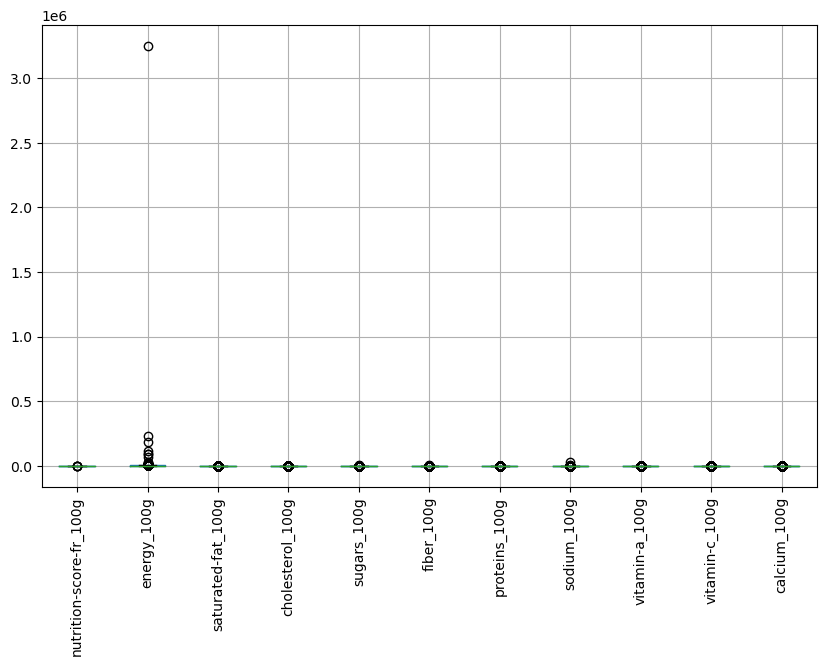

In [89]:
colNumTested = [colgarder[i] for i,colk in enumerate(numCol)  ]
data_cleaned[colNumTested].boxplot(rot=90,figsize = (10,6))
del colNumTested;

In [90]:
data_cleaned[data_cleaned.energy_100g==data_cleaned.energy_100g.max()][['energy_100g','url']]

,energy_100g,url
212928,3251373.0,http://world-fr.openfoodfacts.org/produit/3257983143096/pois-casses-cora


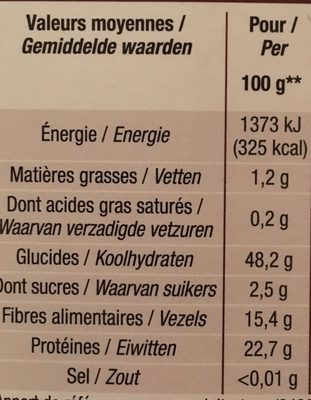

In [91]:
data_cleaned.loc[data_cleaned.code=='3257983143096','energy_100g'] = 1373
data_cleaned.loc[data_cleaned.code=='8710573641501','energy_100g'] = 2312
data_cleaned.loc[data_cleaned.code=='3661405001053','energy_100g'] = 764
data_cleaned.loc[data_cleaned.code=='0201203040026','energy_100g'] = 3700
data_cleaned.loc[data_cleaned.code=='0619309100979','energy_100g'] = 92

#### Les valeurs négatives

In [92]:
data_cleaned[numCol].apply(lambda x : x<0).sum()

nutrition-score-fr_100g        35132
energy_100g                        0
saturated-fat_100g                 0
cholesterol_100g                   0
sugars_100g                        7
fiber_100g                         1
proteins_100g                      3
sodium_100g                        0
vitamin-a_100g                     1
vitamin-c_100g                     1
calcium_100g                       0
iron_100g                          1
fruits-vegetables-nuts_100g        0
bocal/conserve                     0
creme/sauce                        0
litre                              0
petit pot/yaourt                   0
poids                              0
unité                              0
dtype: int64

In [93]:
for col in ['sugars_100g','fiber_100g','proteins_100g','vitamin-a_100g','vitamin-c_100g','iron_100g','trans-fat_100g']:
    print(data_cleaned[data_cleaned[col]<0].url,col)

8582                                                                     http://world-fr.openfoodfacts.org/produit/0011213420608/grade-a-fancy-chopped-spinach-spartan
18209                                                       http://world-fr.openfoodfacts.org/produit/0021130493432/select-spicy-red-bell-pepper-pasta-sauce-signature
117739                                                                      http://world-fr.openfoodfacts.org/produit/0608866999263/hummous-black-truffle-the-wild-pea
146284                                                             http://world-fr.openfoodfacts.org/produit/0789280259062/crackers-partners-a-tasteful-choice-company
150858    http://world-fr.openfoodfacts.org/produit/0813922021028/italianavera-tomato-sauce-with-gaeta-olives-sicilian-capers-olives-sicilian-capers-italiana-vera-srl
164030                                                                         http://world-fr.openfoodfacts.org/produit/0856336001538/organic-pumpkin-seeds-cb-s-nut

In [94]:
# sugars_100g
data_cleaned.loc[data_cleaned.code=='0011213420608','sugars_100g'] = 1.2
data_cleaned.loc[data_cleaned.code=='0021130493432','sugars_100g'] = 2.4
data_cleaned.loc[data_cleaned.code=='0608866999263','sugars_100g'] = 0
data_cleaned.loc[data_cleaned.code=='0789280259062','sugars_100g'] = 6.67 
data_cleaned.loc[data_cleaned.code=='0813922021028','sugars_100g'] = 3.75
data_cleaned.loc[data_cleaned.code=='0856336001538','sugars_100g'] = 0
data_cleaned.loc[data_cleaned.code=='3161716740011','sugars_100g'] = 0.5

# fiber_100g
data_cleaned.loc[data_cleaned.code=='0028400231053','fiber_100g'] = np.nan

# proteins_100g
data_cleaned.loc[data_cleaned.code=='0036800416727','proteins_100g'] = 17.86
data_cleaned.loc[data_cleaned.code=='04029816','proteins_100g'] = np.nan
data_cleaned.loc[data_cleaned.code=='0875208001230','proteins_100g'] = 0

# vitamin-a_100g
data_cleaned.loc[data_cleaned.code=='0072392312726','vitamin-a_100g'] = np.nan

# vitamin-c_100g
data_cleaned.loc[data_cleaned.code=='0041262272323','vitamin-c_100g'] = 0

# iron_100g
data_cleaned.loc[data_cleaned.code=='8850781702899','iron_100g'] = np.nan

# trans-fat_100g
# les erreurs seront remplacées par 0
data_cleaned.loc[data_cleaned['trans-fat_100g']<0,'trans-fat_100g'] = 0

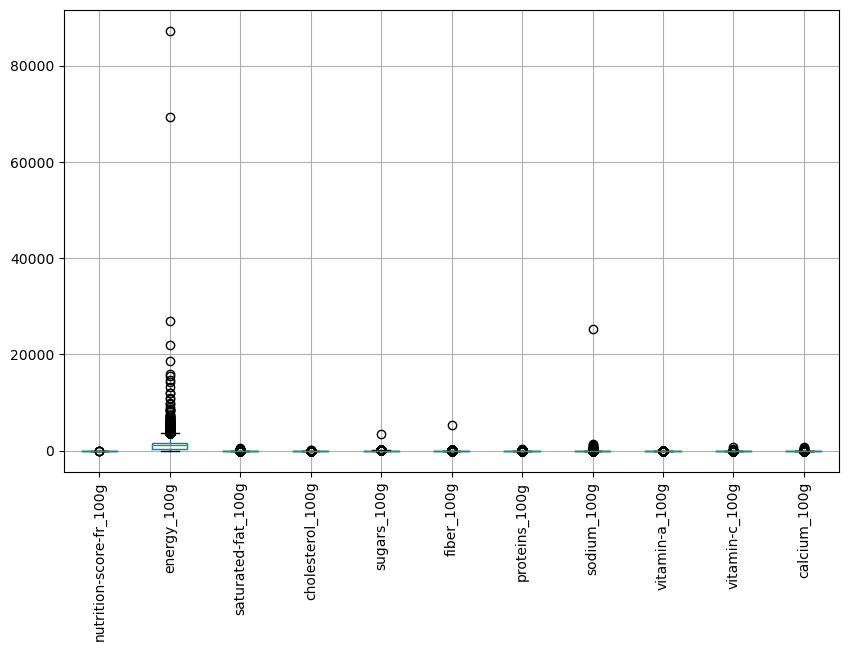

In [95]:
colNumTested = [colgarder[i] for i,colk in enumerate(numCol)  ]
data_cleaned[colNumTested].boxplot(rot=90,figsize = (10,6))
del colNumTested;

</br>

#### Analisons les outliers, plus en profondeurs

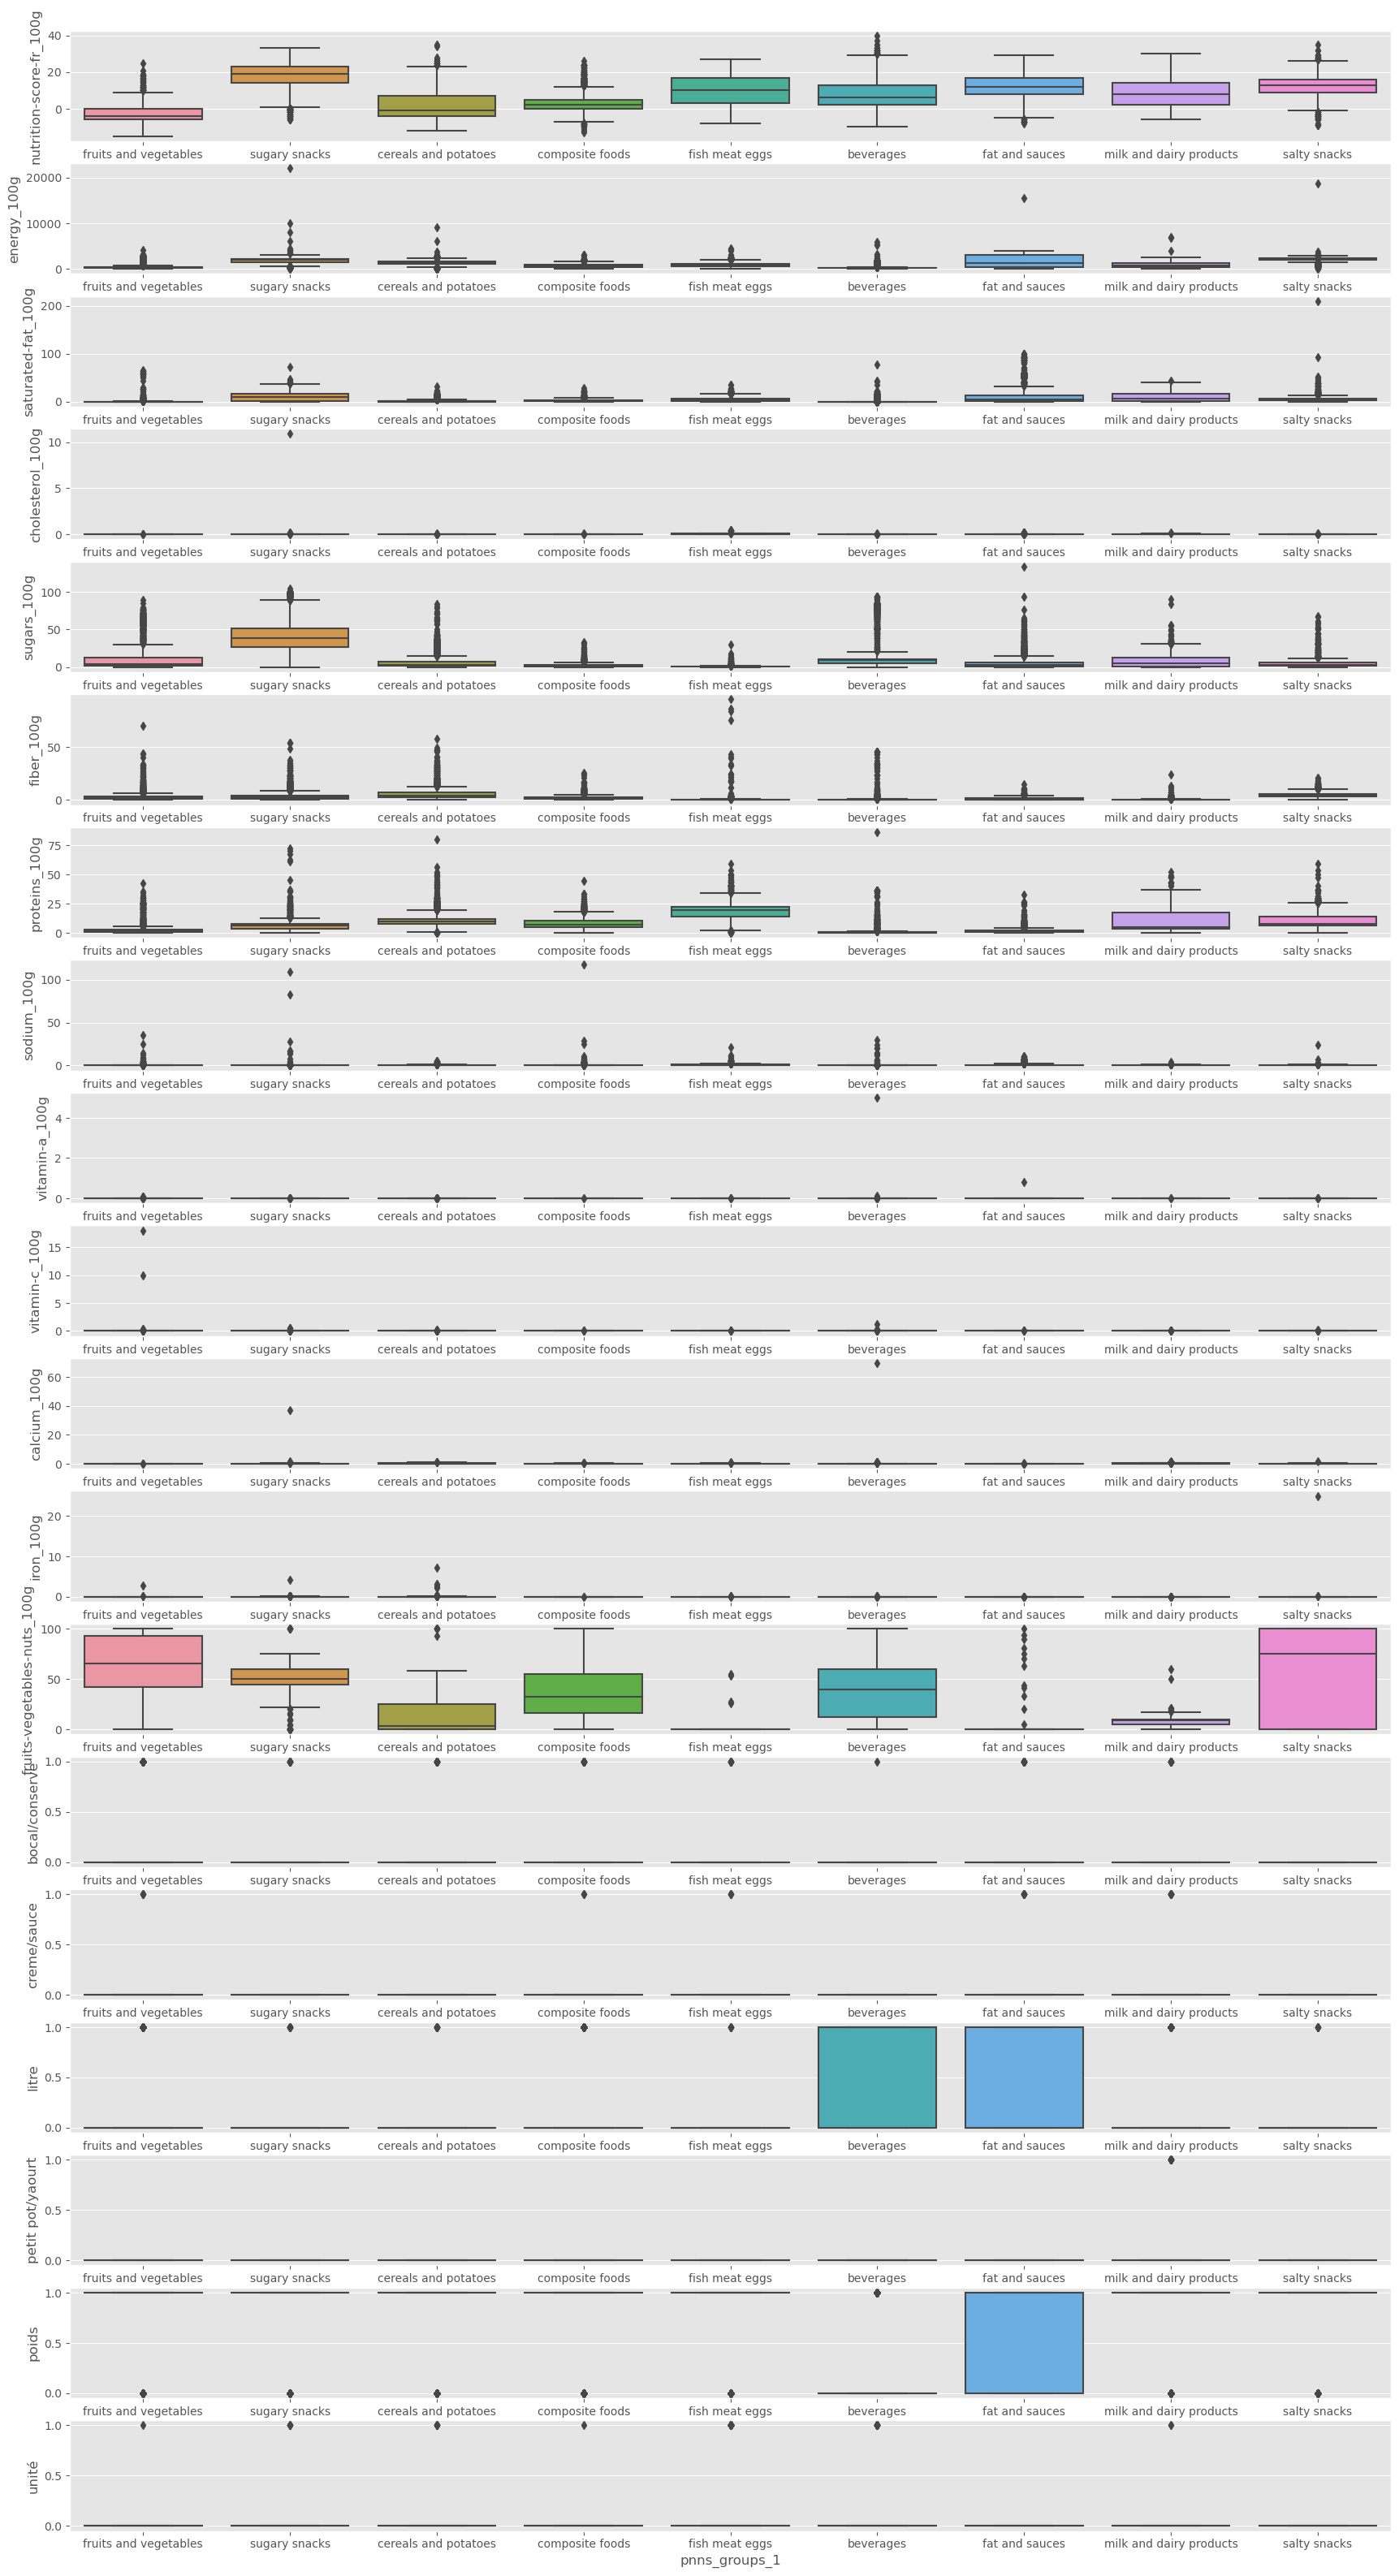

In [96]:
plt.style.use('ggplot')
fig,axes = plt.subplots(nrows = len(numCol),ncols = 1,figsize=(21,40))
for i,col in enumerate( numCol ):
    sns.boxplot(x= 'pnns_groups_1',y= col,data = data_cleaned,ax=axes[i])
    #axes.flatten()[i-imp].set_title(col)    

</br>

#### Etude de la normalité des variables numeriques

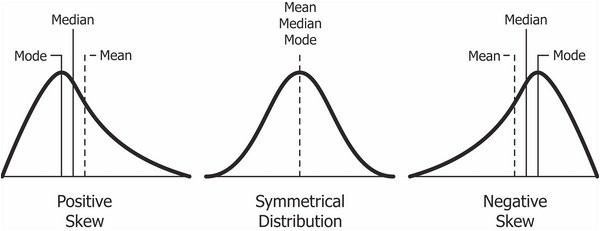

In [97]:
from scipy import stats

df_normalite = pd.DataFrame()
list_col = []
list_Shapiro = []
list_kstest = []
list_skewness = []

for i,col in enumerate([x for x in numCol if '_100g' in x]):
    list_col.append(col)
    list_Shapiro.append(stats.shapiro(data_cleaned[col].dropna())[1])
    list_kstest.append(stats.kstest(data_cleaned[col].dropna(), 'norm')[1])
    list_skewness.append(stats.skew(data_cleaned[col].dropna()) )
    
df_normalite['Colonne'] = list_col
df_normalite['pvalue_Shapiro'] = list_Shapiro
df_normalite['pvalue_Kolmogorov-Smirnov'] = list_kstest
df_normalite['skewness_empirique'] = list_skewness

del list_kstest,list_col,list_Shapiro,list_skewness

df_normalite

C:\Users\eleor\anaconda3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,Colonne,pvalue_Shapiro,pvalue_Kolmogorov-Smirnov,skewness_empirique
0,nutrition-score-fr_100g,0.0,0.0,0.114248
1,energy_100g,0.0,0.0,7.100063
2,saturated-fat_100g,0.0,0.0,4.830517
3,cholesterol_100g,0.0,0.0,266.719915
4,sugars_100g,0.0,0.0,17.333801
5,fiber_100g,0.0,0.0,361.871850
6,proteins_100g,0.0,0.0,2.628253
7,sodium_100g,0.0,0.0,490.134757
8,vitamin-a_100g,0.0,0.0,350.629441
9,vitamin-c_100g,0.0,0.0,267.005396


#### Densité de distribution

<div class="alert alert-block alert-warning">
Aucunes de ces colonnes ne suivent la distribution d'une loi normal.
</br>
Donc definir que les valeurs outliers sont les valeurs plus grandes que 3 n'est pas exacte.
(95% des valeurs d'une distribution normale se situe entre -1.96 et 1.96 et 99% des valeurs d'une distribution normale se situe entre -3 et 3)

</br></br>
Nous traiterons les outliers grace à l'écart intercartile
</div>

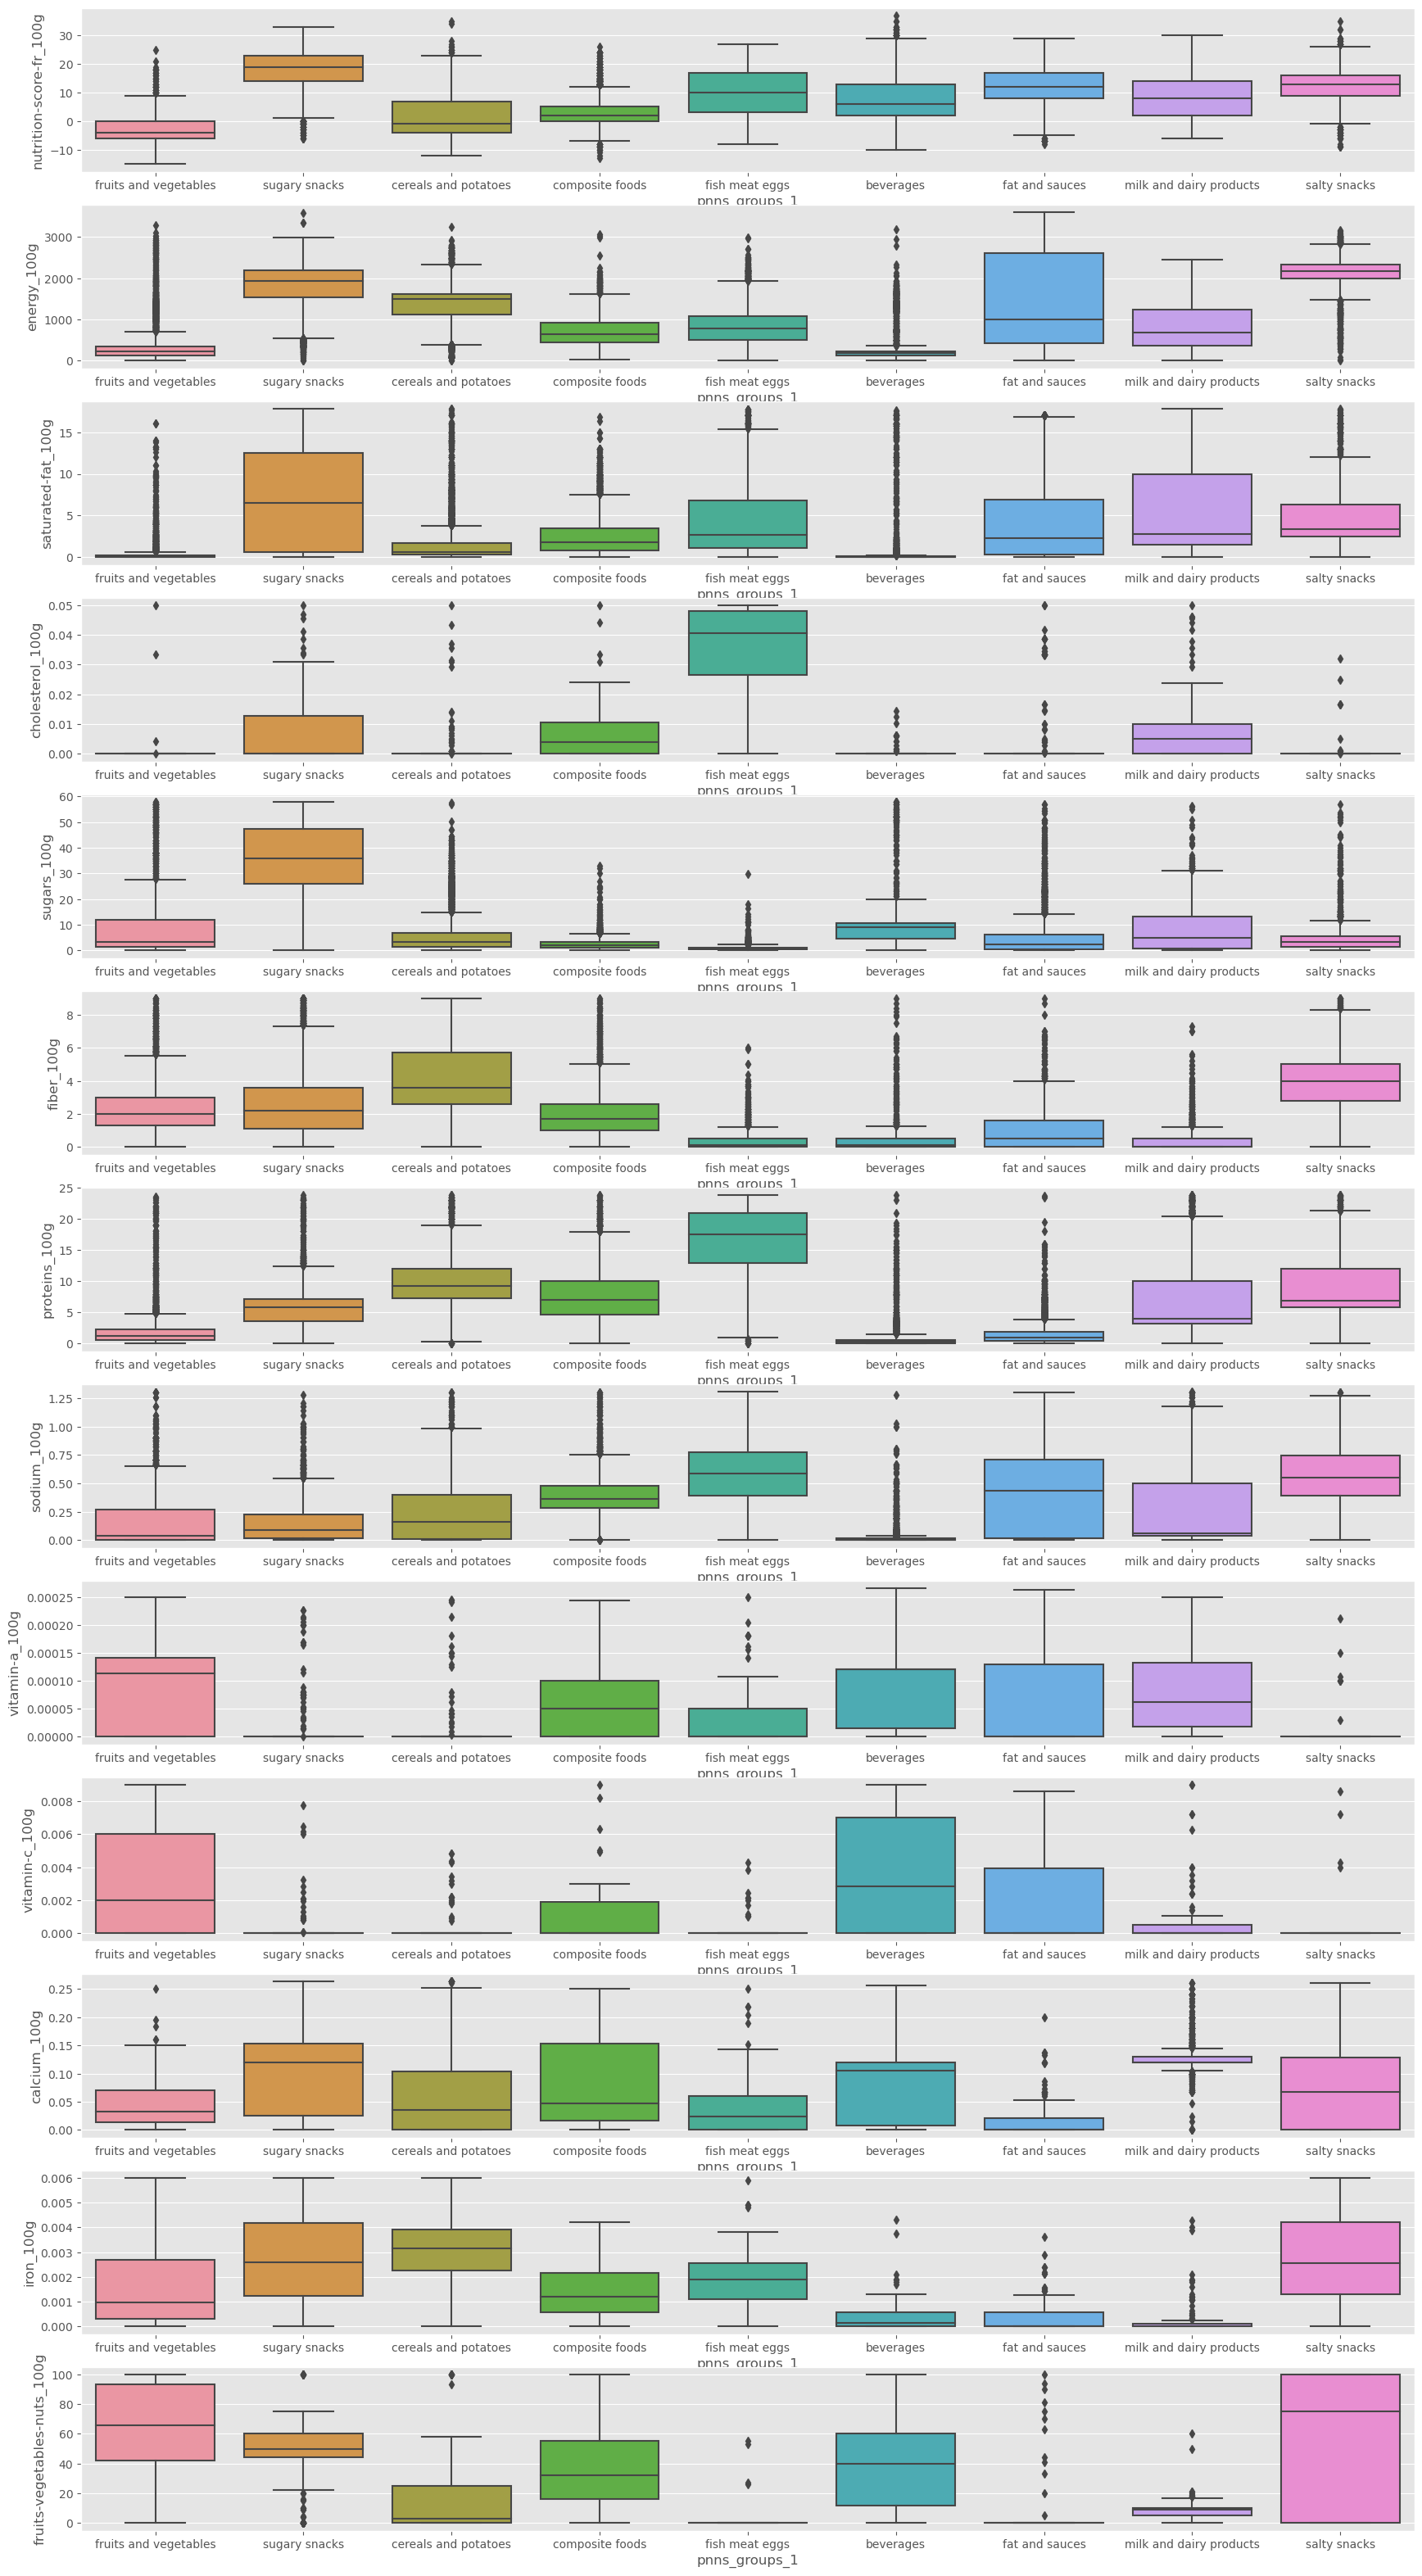

In [98]:
plt.style.use('ggplot')
fig,axes = plt.subplots(nrows = len([x for x in data_cleaned[numCol].columns if '_100g' in x]),ncols = 1,figsize=(21,40))
for i,col in enumerate( numCol ):
    if '_100g' in col:
        
        #On calcule Q1 et Q3
        q1,q3=data_cleaned[col].quantile(q=0.25),data_cleaned[col].quantile(q=0.75)

        #On calcule l'écart interquartile (IQR)
        IQR=q3-q1

        #On calcule la borne inférieure à l'aide du Q1 et de l'écart interquartile
        borne_inf = q1-1.5*IQR

        #On calcule la borne supérieure à l'aide du Q3 et de l'écart interquartile
        borne_sup = q3 +1.5*IQR

        #On garde les valeurs à l'intérieur de la borne inférieure et supérieure
        data_cleaned.loc[data_cleaned[col]>borne_sup,col] = np.nan
        data_cleaned.loc[data_cleaned[col]<borne_inf,col] = np.nan
        
        sns.boxplot(x= 'pnns_groups_1',y= col,data = data_cleaned,ax=axes[i])
        #axes.flatten()[i-imp].set_title(col)

del q1,q3,IQR,borne_inf,borne_sup

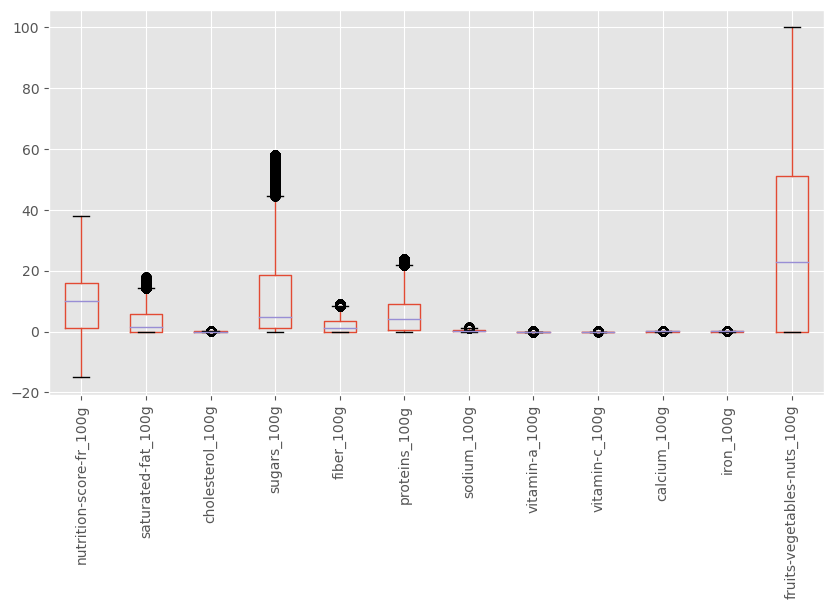

In [99]:
plt.style.use('ggplot')
plt.figure(figsize=(10,5))
colNumTested = [colk for i,colk in enumerate(numCol) if '_100g' in colk ]
colNumTested.remove('energy_100g')
data_cleaned[colNumTested].boxplot(rot=90,figsize = (10,6))
del colNumTested;

Les valeurs de l'energy_100g ne sont pas dans le même ordre de grandeur que celle des autres colonnes.</br>
Il faudra centré et réduire les données.

In [101]:
data_cleaned.shape

(316836, 93)

In [102]:
data_cleaned.columns

Index(['code', 'url', 'creator', 'created_t', 'last_modified_t',
       'product_name', 'generic_name', 'quantity', 'packaging_tags',
       'brands_tags', 'categories_tags', 'origins_tags',
       'manufacturing_places_tags', 'labels_tags', 'emb_codes_tags',
       'first_packaging_code_geo', 'purchase_places', 'stores', 'countries_fr',
       'ingredients_text', 'allergens', 'traces_tags', 'serving_size',
       'additives_n', 'additives_tags', 'ingredients_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil_n', 'nutrition_grade_fr',
       'pnns_groups_1', 'pnns_groups_2', 'states_tags', 'main_category_fr',
       'image_url', 'image_small_url', 'energy_100g', 'energy-from-fat_100g',
       'fat_100g', 'saturated-fat_100g', 'monounsaturated-fat_100g',
       'polyunsaturated-fat_100g', 'omega-3-fat_100g',
       'alpha-linolenic-acid_100g', 'omega-6-fat_100g', 'trans-fat_100g',
       'cholesterol_100g', 'carbohydrates_100g', 'sugars_100g', 'lactose_100g',
       'starch

In [103]:
data_cleaned.to_csv('df_openfoodfacts_intermediaire.csv',sep="\t",index=False)

In [104]:
import pickle
with open('colagarder.bin','wb') as fichier:
    pickle.dump(colgarder,fichier)

</br>

</br>

</br>

</br>

</br>

</br>

</br>

</br>

</br>

</br>

</br>

</br>

</br>

In [100]:
%whos

Variable                   Type         Data/Info
-------------------------------------------------
IQR                        float64      51.0
a                          float64      2.54
axes                       ndarray      13: 13 elems, type `object`, 104 bytes
b                          float64      0.0
borne_inf                  float64      -76.5
borne_sup                  float64      127.5
col                        str          unité
col_to_drop                list         n=65
colgarder                  list         n=27
compute_nb_mising_values   function     <function compute_nb_misi<...>es at 0x000001F34F1523A0>
data_cleaned               DataFrame                     code  \\<...>316836 rows x 93 columns]
df_normalite               DataFrame                            C<...>n12            0.683363  
drop_duplicated_col        function     <function drop_duplicated<...>ol at 0x000001F34F0FA430>
fig                        Figure       Figure(2100x4000)
general_informati